In [ ]:
# required libs
import numpy as np
import random
import time
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim


In [ ]:
import random
import numpy as np

class SimpleGridEnv:
    def __init__(self, tele_prob_goal=0.3, tele_prob_enemy=0.3, tele_prob_random=0.4):
        self.size = 7
        self.center = (3, 3)
        self.goal = (3, 3)

        # Teleport probabilities (must sum to 1)
        self.tele_p_goal = tele_prob_goal
        self.tele_p_enemy = tele_prob_enemy
        self.tele_p_rand = tele_prob_random
        self.teleporter = (0, 3)

        # Enemy Manhattan-radius-2 loops around goal
        # Clockwise and Counterclockwise paths
        self.enemy1_path = self._circle_path(clockwise=True)
        self.enemy2_path = self._circle_path(clockwise=False)

        self.reset()

    def _circle_path(self, clockwise=True):
       cx, cy = self.goal
       loop = [
            (cx, cy+2),  # top
            (cx+1, cy+1),
            (cx+2, cy),
            (cx+1, cy-1),
            (cx, cy-2),
            (cx-1, cy-1),
            (cx-2, cy),
            (cx-1, cy+1)
        ]
       return loop if clockwise else list(reversed(loop))

    def reset(self):
        corners = [(0,0),(0,6),(6,0),(6,6)]
        self.agent = random.choice(corners)
        self.e1_idx = 0
        self.e2_idx = 0
        self.enemy1 = self.enemy1_path[self.e1_idx]
        self.enemy2 = self.enemy2_path[self.e2_idx]
        return self.state()

    def state(self):
        return (
            self.agent[0], self.agent[1],
            self.enemy1[0], self.enemy1[1],
            self.enemy2[0], self.enemy2[1]
        )

    def _move_enemies(self):
        self.e1_idx = (self.e1_idx + 1) % len(self.enemy1_path)
        self.e2_idx = (self.e2_idx + 1) % len(self.enemy2_path)
        self.enemy1 = self.enemy1_path[self.e1_idx]
        self.enemy2 = self.enemy2_path[self.e2_idx]

    def _teleport(self):
        r = random.random()
        if r < self.tele_p_goal:
            return self.goal
        elif r < self.tele_p_goal + self.tele_p_enemy:
            return random.choice([self.enemy1, self.enemy2])
        else:
            return (random.randint(0,6), random.randint(0,6))

    def step(self, action):
        # Action: 0=up, 1=down, 2=left, 3=right
        x, y = self.agent
        if action == 0: x -= 1
        if action == 1: x += 1
        if action == 2: y -= 1
        if action == 3: y += 1

        x = max(0, min(6, x))
        y = max(0, min(6, y))
        self.agent = (x, y)

        # Teleporter
        if self.agent == self.teleporter:
            self.agent = self._teleport()
        # Move enemies
        self._move_enemies()
        # Reward & terminal conditions
        reward = -1
        done = False
        if self.agent == self.center:
            reward = 50
            done = True
        if self.agent == self.enemy1 or self.agent == self.enemy2:
            reward = -20
            done = True
        return self.state(), reward, done
def ascii_render(env):
    grid = [['.' for _ in range(env.size)] for _ in range(env.size)]
    # obstacles
    ax, ay = env.agent
    gx, gy = env.goal
    e1x, e1y = env.enemy1
    e2x, e2y = env.enemy2
    tx,ty=env.teleporter
    grid[tx][ty]='T'
    grid[ax][ay] = 'A'
    grid[gx][gy] = 'G'
    grid[e1x][e1y] = '1'
    grid[e2x][e2y] = '2'
    for row in grid:
        print(' '.join(row))
    print("="*20)

def animate_agent(agent, env, episodes=1, delay=0.2):
    for ep in range(episodes):
        s = env.reset()
        for t in range(200):
            ascii_render(env)
            a = agent.act(s)
            s, r, done = env.step(a)
            time.sleep(delay)
            if done:
                ascii_render(env)
                print("Done, reward:", r)
                break


In [ ]:
import random
import time
import numpy as np

class SimpleGridEnv25_Complex:
    """
    Single-file environment:
    - 25x25 grid (index 0..24), center goal at (12,12)
    - 3 enemies circling at Manhattan radii 3,5,7
    - Two diamond wall rings at radii 4 and 8 (4 holes each at cardinals)
    - 3 teleporters with different probability mixes
    - Stochastic action outcomes
    - Agent starts in a random corner
    State: (ax,ay, e1x,e1y, e2x,e2y, e3x,e3y)
    Actions: 0=up,1=down,2=left,3=right
    """

    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.size = 25
        self.center = (12, 12)
        self.goal = self.center

        # Teleporters (fixed coords) and their probability tuples: (p_goal, p_enemy, p_random)
        self.teleporters = {
            (0, 12): (0.4, 0.3, 0.3),   # top center — biased to goal
            (12, 0): (0.2, 0.5, 0.3),   # left center — biased to enemy
            (24, 12): (0.1, 0.2, 0.7),  # bottom center — mostly random
        }

        # Stochastic transition model: intended action -> list of (move_name, prob)
        # Move names: 'up','down','left','right','stay'
        self.action_transitions = {
            0: [('up', 1)],
            1: [('down', 1)],  # down
            2: [('left', 1)],     # left
            3: [('right',1)],    # right
        }

        # Wall radii as requested (Option A spacing)
        self.inner_wall_radius = 4
        self.outer_wall_radius = 8

        # Enemy radii as requested (Preset 1)
        self.enemy_radii = [3, 5, 7]

        # Build enemy paths
        self.enemy_paths = [self._diamond_path(r) for r in self.enemy_radii]

        # Build wall rings with 4 cardinal holes each
        self.walls = set()
        self._build_wall_rings_with_cardinal_holes()

        # initialize
        self.reset()

    def _diamond_path(self, radius):
        """Return Manhattan diamond loop of given radius in clockwise order around self.center."""
        cx, cy = self.center
        pts = []
        for i in range(radius + 1):
            pts.append((cx + i, cy + (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx + (radius - i), cy - i))
        for i in range(1, radius + 1):
            pts.append((cx - i, cy - (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx - (radius - i), cy + i))
        return pts

    def _diamond_coords(self, r):
        """Return all coords exactly at Manhattan distance r from center."""
        cx, cy = self.center
        coords = []
        for x in range(self.size):
            for y in range(self.size):
                if abs(x - cx) + abs(y - cy) == r:
                    coords.append((x, y))
        coords.sort()
        return coords

    def _build_wall_rings_with_cardinal_holes(self):
        """Create inner and outer diamond rings; carve 4 cardinal holes on each ring."""
        cx, cy = self.center

        inner = set(self._diamond_coords(self.inner_wall_radius))
        outer = set(self._diamond_coords(self.outer_wall_radius))

        # 4 cardinal holes each: top, right, bottom, left
        inner_holes = {
            (cx, cy + self.inner_wall_radius),
            (cx + self.inner_wall_radius, cy),
            (cx, cy - self.inner_wall_radius),
            (cx - self.inner_wall_radius, cy)
        }
        outer_holes = {
            (cx, cy + self.outer_wall_radius),
            (cx + self.outer_wall_radius, cy),
            (cx, cy - self.outer_wall_radius),
            (cx - self.outer_wall_radius, cy)
        }

        for h in inner_holes:
            inner.discard(h)
        for h in outer_holes:
            outer.discard(h)

        self.walls = inner.union(outer)

        # Ensure teleporters and goal aren't walls
        for t in self.teleporters.keys():
            self.walls.discard(t)
        self.walls.discard(self.goal)

    def reset(self):
        corners = [(0, 0), (0, self.size - 1), (self.size - 1, 0), (self.size - 1, self.size - 1)]
        self.agent = random.choice(corners)

        # enemy indices staggered so enemies are spaced around their loops
        self.e_idx = []
        for pth in self.enemy_paths:
            # pick indices spaced apart so they start at different positions
            # use offsets: 0, len/3, 2*len/3 (rounded)
            L = len(pth)
            if L == 0:
                self.e_idx.append(0)
            else:
                # small random offset to avoid perfect sync across runs
                self.e_idx.append((len(self.e_idx) * (L // 3)) % L)

        self.enemies = [pth[idx % len(pth)] for pth, idx in zip(self.enemy_paths, self.e_idx)]
        return self.state()

    def state(self):
        ax, ay = self.agent
        return (
            ax, ay,
            self.enemies[0][0], self.enemies[0][1],
            self.enemies[1][0], self.enemies[1][1],
            self.enemies[2][0], self.enemies[2][1],
        )

    def _sample_actual_move(self, intended):
        dist = self.action_transitions[intended]
        r = random.random()
        cum = 0.0
        for mv, p in dist:
            cum += p
            if r <= cum:
                return mv
        return dist[-1][0]

    def _apply_move(self, pos, move):
        x, y = pos
        if move == 'up':
            x -= 1
        elif move == 'down':
            x += 1
        elif move == 'left':
            y -= 1
        elif move == 'right':
            y += 1
        elif move == 'stay':
            pass
        # bounds
        x = max(0, min(self.size - 1, x))
        y = max(0, min(self.size - 1, y))
        return (x, y)

    def _teleport_from(self, tele_pos):
        gp, ep, rp = self.teleporters[tele_pos]
        r = random.random()
        if r < gp:
            return self.goal
        elif r < gp + ep:
            # choose a current enemy uniformly
            return random.choice(self.enemies)
        else:
            # random empty cell (avoid walls for fairness)
            attempts = 0
            while True:
                x = random.randint(0, self.size - 1)
                y = random.randint(0, self.size - 1)
                if (x, y) not in self.walls:
                    return (x, y)
                attempts += 1
                if attempts > 1000:
                    # fallback
                    return (x, y)

    def _move_enemies(self):
        new = []
        for i, pth in enumerate(self.enemy_paths):
            if len(pth) == 0:
                new.append(self.enemies[i])
                continue
            self.e_idx[i] = (self.e_idx[i] + 1) % len(pth)
            new.append(pth[self.e_idx[i]])
        self.enemies = new

    def step(self, action):
        """
        :param action: int 0..3
        :returns: state, reward, done, info
        """
        # 1) sample actual move
        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)

        # 2) walls block movement (unless candidate is a hole)
        if candidate in self.walls:
            # blocked -> stay
            next_agent = self.agent
        else:
            next_agent = candidate

        self.agent = next_agent

        # 3) teleporters
        if self.agent in self.teleporters:
            self.agent = self._teleport_from(self.agent)

        # 4) move enemies
        self._move_enemies()

        # 5) reward & terminal
        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif self.agent in self.enemies:
            reward = -20
            done = True

        return self.state(), reward, done, {}

    def ascii_render(self):
        """Compact 25x25 rendering with single-character map:
        '.' empty, 'W' wall, 'T' teleporter, 'G' goal, 'A' agent, '1','2','3' enemies.
        Rows printed top-to-bottom (0..24).
        """
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]

        # walls
        for (x, y) in self.walls:
            grid[x][y] = 'W'
        # teleporters
        for t in self.teleporters.keys():
            tx, ty = t
            grid[tx][ty] = 'T'
        # goal
        gx, gy = self.goal
        grid[gx][gy] = 'G'
        # enemies
        for i, (ex, ey) in enumerate(self.enemies):
            ch = str((i + 1) % 10)
            grid[ex][ey] = ch
        # agent (override)
        ax, ay = self.agent
        grid[ax][ay] = 'A'

        # print header index row (mod10) for columns
        header = '   ' + ''.join(str(j % 10) for j in range(self.size))
        print(header)
        for i, row in enumerate(grid):
            # left index (mod10) and row content
            print(f'{i % 10:>2} ' + ''.join(row))
        print('-' * (self.size + 4))

    def free_cells(self):
        cells = []
        for x in range(self.size):
            for y in range(self.size):
                if (x, y) not in self.walls and (x, y) not in self.teleporters and (x, y) != self.goal:
                    cells.append((x, y))
        return cells


class RandomAgent:
    def __init__(self, n_actions=4):
        self.n_actions = n_actions
    def act(self, state):
        return random.randrange(self.n_actions)


def animate_agent(agent, env, episodes=1, delay=0.05, max_steps=400):
    """
    Runs episodes and prints full 25x25 grid each step.
    delay seconds between frames (0 for fast).
    """
    for ep in range(episodes):
        s = env.reset()
        print(f'=== Episode {ep+1} start. Agent at {env.agent} ===')
        for t in range(max_steps):
            env.ascii_render()
            a = agent.act(s)
            s, r, done, _ = env.step(a)
            time.sleep(delay)
            if done:
                env.ascii_render()
                print(f'Finished at step {t+1} | reward={r} | agent={env.agent}')
                break
        else:
            print(f'Episode {ep+1} reached max steps ({max_steps}). Final agent pos: {env.agent}')


if __name__ == '__main__':
    # Demo: run one episode with RandomAgent
    env = SimpleGridEnv25_Complex(seed=123)
    agent = RandomAgent()
    # print some diagnostics
    print("Goal:", env.goal)
    print("Teleporters:", env.teleporters)
    print("Enemy radii:", env.enemy_radii)
    print("Inner wall radius:", env.inner_wall_radius, "Outer wall radius:", env.outer_wall_radius)
    print("Number of wall cells:", len(env.walls))
    print("Initial enemies:", env.enemies)
    # animate one short episode (set delay=0 to run quickly)
    animate_agent(agent, env, episodes=1, delay=0.02, max_steps=300)


Streaming output truncated to the last 5000 lines.
 2 .........................
 3 .........................
 4 ............T............
-----------------------------
   0123456789012345678901234
 0 ............T............
 1 .........................
 2 .........................
 3 .........................
 4 .........................
 5 ...........W3W...........
 6 ..........W...W..........
 7 .........W.....W.........
 8 ........W.......W........
 9 .......W...W1W...W.......
 0 ......W...W...W...W......
 1 .....W...W.....W...W.....
 2 T...........G............
 3 .....W...W.....W...W.....
 4 .....AW...W...W...W......
 5 .......W...W.W...W.......
 6 ........W.......W........
 7 .........W..2..W.........
 8 ..........W...W..........
 9 ...........W.W...........
 0 .........................
 1 .........................
 2 .........................
 3 .........................
 4 ............T............
-----------------------------
   0123456789012345678901234
 0 ............T...

TRAINING BOTH AGENTS - COMPREHENSIVE ANALYSIS
Environment: 25x25 Complex Grid
Rewards: Goal=+1000, Enemy=-200, Step=-1, Max Steps=500
Training SARSA...
SARSA Episode 0/5000
SARSA Episode 1000/5000
SARSA Episode 2000/5000
SARSA Episode 3000/5000
SARSA Episode 4000/5000

Training Monte Carlo...
Monte Carlo Episode 0/5000
Monte Carlo Episode 1000/5000
Monte Carlo Episode 2000/5000
Monte Carlo Episode 3000/5000
Monte Carlo Episode 4000/5000

FINAL REWARD COMPARISON
SARSA Average Reward: -215.85
Monte Carlo Average Reward: 426.37
SARSA Success Rate: 0.206
Monte Carlo Success Rate: 0.658

BEHAVIOR METRICS COMPARISON
SARSA Wall Collisions: 58,512
Monte Carlo Wall Collisions: 32,543
SARSA Enemy Collisions: 1,851
Monte Carlo Enemy Collisions: 1,205
SARSA Enemy Avoidances: 24,618
Monte Carlo Enemy Avoidances: 22,909
SARSA Teleport Encounters: 3,395
Monte Carlo Teleport Encounters: 6,284


/tmp/ipython-input-3894162258.py:744: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-3894162258.py:744: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-3894162258.py:750: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.savefig('ADVANCED_RL_BEHAVIOR_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-3894162258.py:750: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  plt.savefig('ADVANCED_RL_BEHAVIOR_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packa

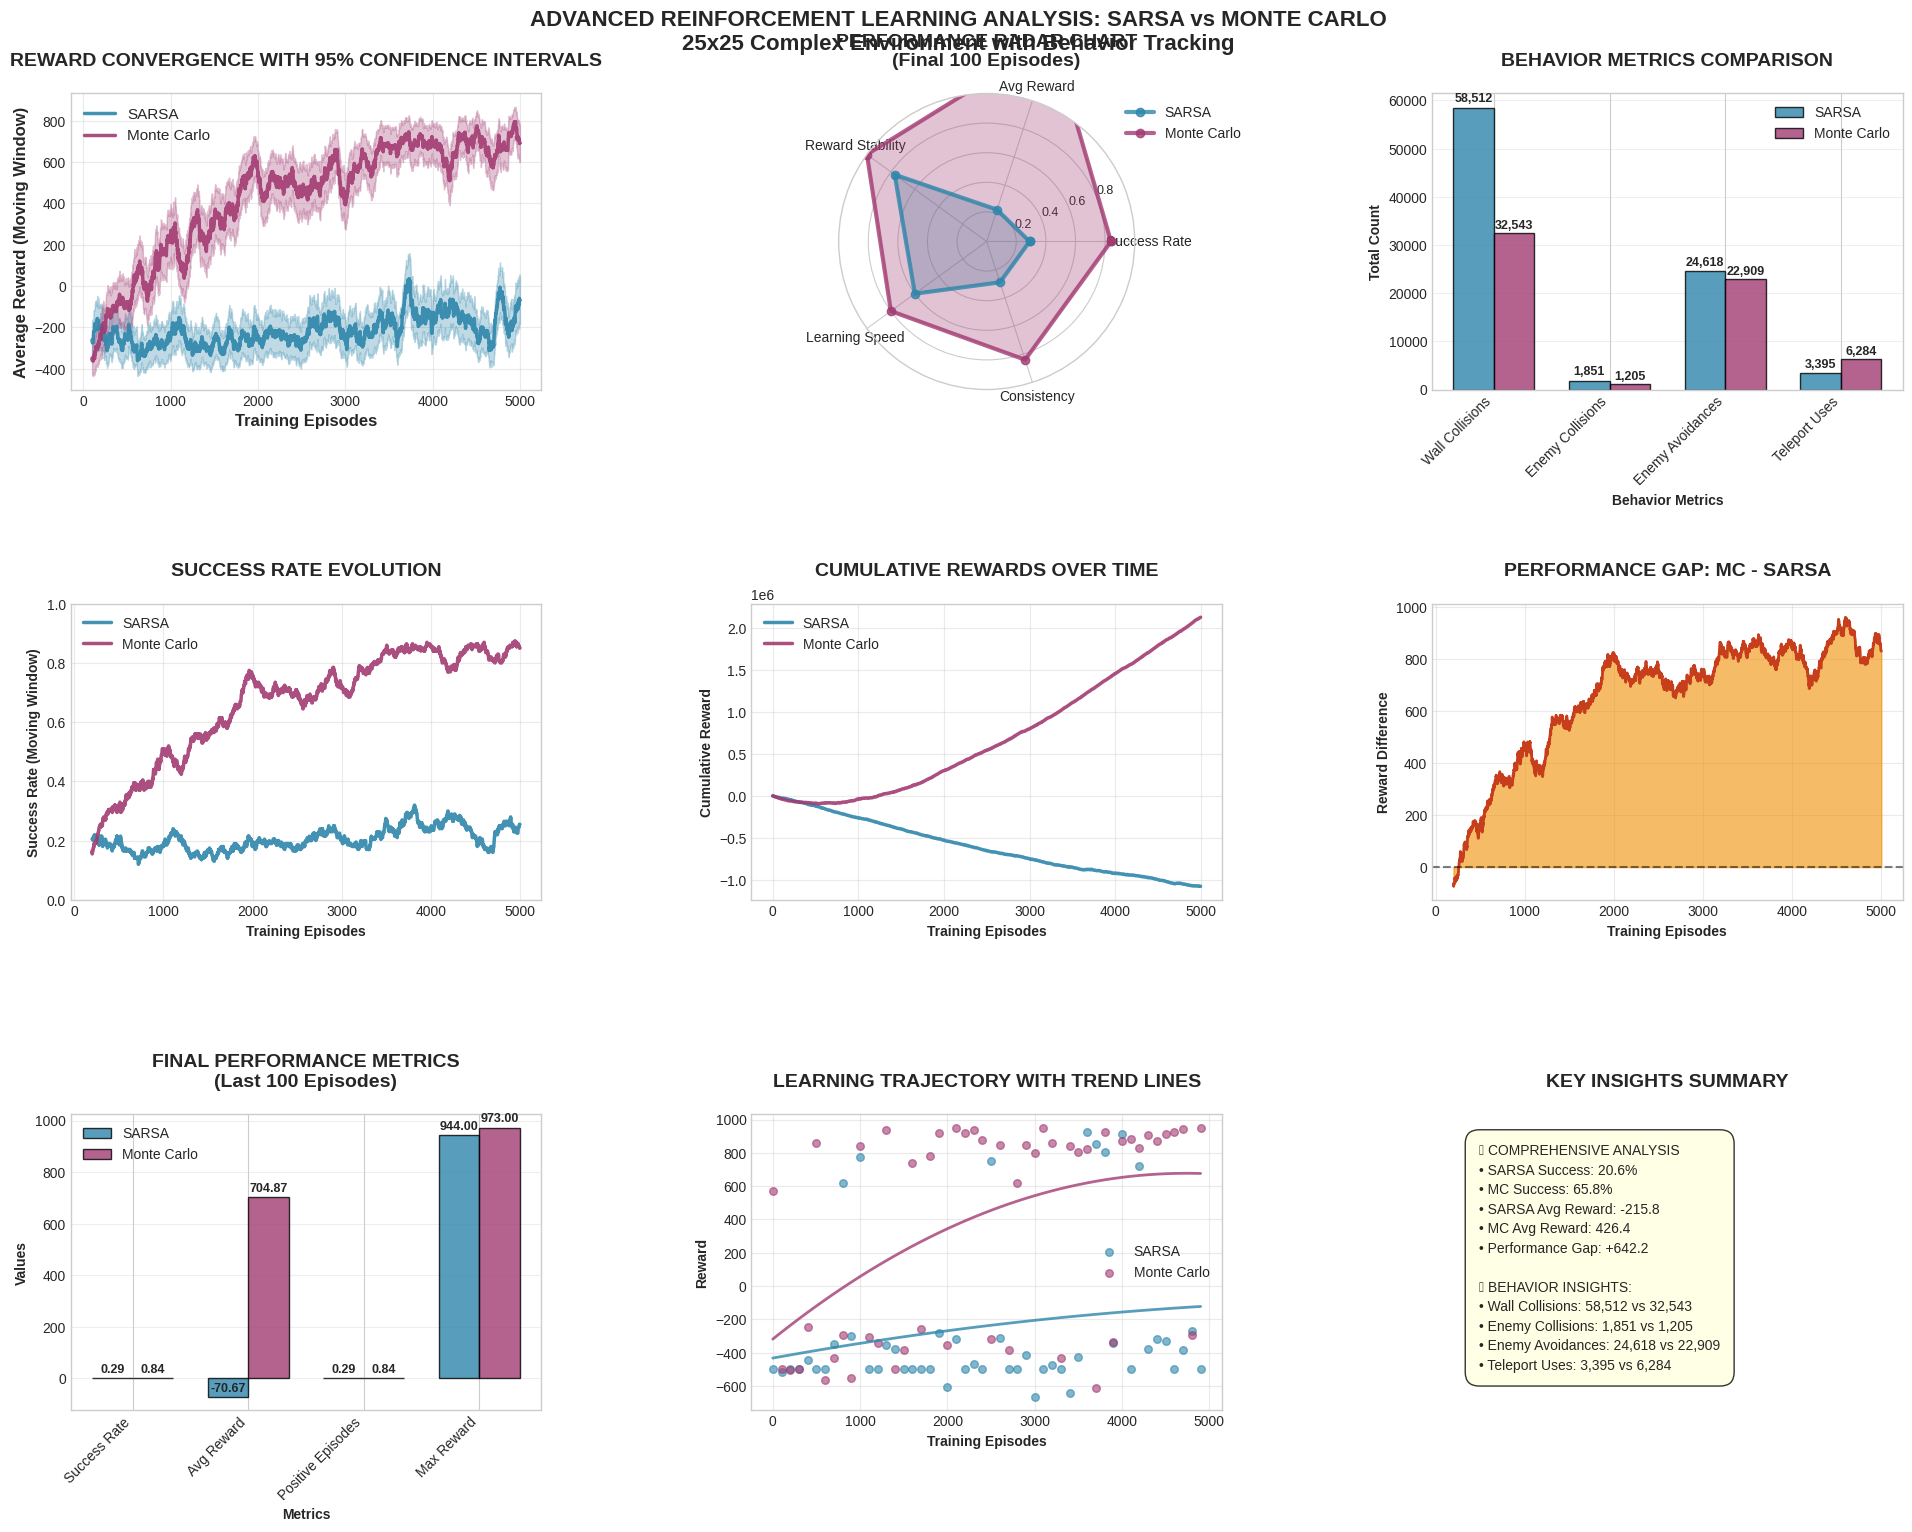


PERFORMANCE ANALYSIS
Monte Carlo performs better by 642.22 average reward
Monte Carlo has 0.452 higher success rate


In [ ]:
import random
import time
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class SimpleGridEnv25_Complex:
    """
    Single-file environment:

    - 25x25 grid (index 0..24), center goal at (12,12)

    - 3 enemies circling at Manhattan radii 3,5,7

    - Two diamond wall rings at radii 4 and 8 (4 holes each at cardinals)

    - 3 teleporters with different probability mixes

    - Stochastic action outcomes
    - Agent starts in a random corner
    State: (ax,ay, e1x,e1y, e2x,e2y, e3x,e3y)


    Actions: 0=up,1=down,2=left,3=right
    """

    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.size = 25
        self.center = (12, 12)
        self.goal = self.center

        # Teleporters (INKE FIXED COORDINATES HAI) and their probability tuples -> (p_goal, p_enemy, p_random)



        self.teleporters = {
            (0, 12): (0.4, 0.3, 0.3),   # top center.   — biased to goal
            (12, 0): (0.2, 0.5, 0.3),   # left center  — biased to enemy
            (24, 12): (0.1, 0.2, 0.7),  # bottom center  — mostly random
        }

        # Stochastic transition model: intended action -> list of (move_name, prob)


        # Move names: 'up','down','left','right','stay'


        self.action_transitions = {
            0: [('up', 1)],
            1: [('down', 1)],  # down
            2: [('left', 1)],     # left
            3: [('right',1)],    # right
        }

        # Wall radii as chahiye thi (Option A spacing)


        self.inner_wall_radius = 4
        self.outer_wall_radius = 8

        # Enemy radii as chahiye thi (Preset 1)


        self.enemy_radii = [3, 5, 7]

        # Building enemy paths


        self.enemy_paths = [self._diamond_path(r) for r in self.enemy_radii]

        # Building  wall rings with 4 cardinal holes each


        self.walls = set()
        self._build_wall_rings_with_cardinal_holes()

        # initializing

        self.reset()

    def _diamond_path(self, radius):


        """Return Manhattan diamond loop of given radius in clockwise order around self.center."""




        cx, cy = self.center
        pts = []
        for i in range(radius + 1):
            pts.append((cx + i, cy + (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx + (radius - i), cy - i))
        for i in range(1, radius + 1):
            pts.append((cx - i, cy - (radius - i)))
        for i in range(1, radius + 1):
            pts.append((cx - (radius - i), cy + i))
        return pts

    def _diamond_coords(self, r):



        """Return all coords exactly at Manhattan distance r from center."""



        cx, cy = self.center
        coords = []
        for x in range(self.size):
            for y in range(self.size):
                if abs(x - cx) + abs(y - cy) == r:
                    coords.append((x, y))
        coords.sort()
        return coords

    def _build_wall_rings_with_cardinal_holes(self):


        """Create inner and outer diamond rings; carve 4 cardinal holes on each ring."""


        cx, cy = self.center

        inner = set(self._diamond_coords(self.inner_wall_radius))
        outer = set(self._diamond_coords(self.outer_wall_radius))

        # 4 cardinal holes each: top, right, bottom, left


        inner_holes = {
            (cx, cy + self.inner_wall_radius),
            (cx + self.inner_wall_radius, cy),
            (cx, cy - self.inner_wall_radius),
            (cx - self.inner_wall_radius, cy)
        }
        outer_holes = {
            (cx, cy + self.outer_wall_radius),
            (cx + self.outer_wall_radius, cy),
            (cx, cy - self.outer_wall_radius),
            (cx - self.outer_wall_radius, cy)
        }

        for h in inner_holes:
            inner.discard(h)
        for h in outer_holes:
            outer.discard(h)

        self.walls = inner.union(outer)

        # Ensure teleporters and goal aren't walls



        for t in self.teleporters.keys():
            self.walls.discard(t)
        self.walls.discard(self.goal)

    def reset(self):
        corners = [(0, 0), (0, self.size - 1), (self.size - 1, 0), (self.size - 1, self.size - 1)]
        self.agent = random.choice(corners)

        # enemy indices staggered so enemies are spaced around their loops


        self.e_idx = []


        for pth in self.enemy_paths:


            # pick indices spaced apart so they start at different positions


            # use offsets: 0, len/3, 2*len/3 (rounding karna hai boss)


            L = len(pth)
            if L == 0:
                self.e_idx.append(0)
            else:
                # small random offset to avoid perfect sync across runs


                self.e_idx.append((len(self.e_idx) * (L // 3)) % L)

        self.enemies = [pth[idx % len(pth)] for pth, idx in zip(self.enemy_paths, self.e_idx)]
        return self.state()

    def state(self):

        ax, ay = self.agent
        return (
            ax, ay,
            self.enemies[0][0], self.enemies[0][1],
            self.enemies[1][0], self.enemies[1][1],
            self.enemies[2][0], self.enemies[2][1],
        )

    def _sample_actual_move(self, intended):


        dist = self.action_transitions[intended]
        r = random.random()
        cum = 0.0
        for mv, p in dist:
            cum += p
            if r <= cum:
                return mv
        return dist[-1][0]

    def _apply_move(self, pos, move):



        x, y = pos

        if move == 'up':
            x -= 1

        elif move == 'down':

            x += 1
        elif move == 'left':
            y -= 1
        elif move == 'right':


            y += 1
        elif move == 'stay':
            pass



        # bounds
        x = max(0, min(self.size - 1, x))

        y = max(0, min(self.size - 1, y))

        return (x, y)

    def _teleport_from(self, tele_pos):



        gp, ep, rp = self.teleporters[tele_pos]
        r = random.random()

        if r < gp:
            return self.goal

        elif r < gp + ep:
            # choose a current enemy uniformly


            return random.choice(self.enemies)

        else:
            # random empty cell (avoid walls for fairness)


            attempts = 0
            while True:
                x = random.randint(0, self.size - 1)
                y = random.randint(0, self.size - 1)
                if (x, y) not in self.walls:
                    return (x, y)
                attempts += 1
                if attempts > 1000:
                    # fallback
                    return (x, y)

    def _move_enemies(self):



        new = []
        for i, pth in enumerate(self.enemy_paths):
            if len(pth) == 0:
                new.append(self.enemies[i])
                continue
            self.e_idx[i] = (self.e_idx[i] + 1) % len(pth)
            new.append(pth[self.e_idx[i]])
        self.enemies = new

    def _check_near_enemy(self):



        """Check if agent is within 2 steps of any enemy"""



        ax, ay = self.agent
        for enemy in self.enemies:
            ex, ey = enemy
            distance = abs(ax - ex) + abs(ay - ey)  # Manhattan distance
            if distance <= 2:
                return True
        return False

    def step(self, action):



        # Store original position for tracking

        old_agent = self.agent

        # 1) sample actual move


        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)

        # 2) walls block movement - TRACK COLLISIONS


        wall_collision = False



        if candidate in self.walls:
            # blocked -> stay
            next_agent = self.agent
            wall_collision = True
        else:
            next_agent = candidate

        self.agent = next_agent

        # 3) teleporters - TRACK TELEPORTATION


        teleported = False
        if self.agent in self.teleporters:
            old_pos = self.agent
            self.agent = self._teleport_from(self.agent)
            teleported = (old_pos != self.agent)

        # 4) move enemies
        self._move_enemies()

        # 5) Check enemy proximity and collisions


        enemy_collision = self.agent in self.enemies
        near_enemy = self._check_near_enemy()

        # 6) reward & terminal


        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif enemy_collision:
            reward = -200
            done = True

        # Create info dictionary with all tracking metrics


        info = {
            'wall_collision': wall_collision,
            'enemy_collision': enemy_collision,
            'near_enemy': near_enemy,
            'teleported': teleported,
            'actual_move': actual_move
        }

        return self.state(), reward, done, info

    def ascii_render(self):


        """Compact 25x25 rendering with single-character map:
        '.' empty, 'W' wall, 'T' teleporter, 'G' goal, 'A' agent, '1','2','3' enemies.
        Rows printed top-to-bottom (0..24).
        """
        grid = [['.' for _ in range(self.size)] for _ in range(self.size)]

        # walls


        for (x, y) in self.walls:
            grid[x][y] = 'W'


        # teleporters
        for t in self.teleporters.keys():
            tx, ty = t
            grid[tx][ty] = 'T'



        # goal
        gx, gy = self.goal
        grid[gx][gy] = 'G'



        # enemies
        for i, (ex, ey) in enumerate(self.enemies):
            ch = str((i + 1) % 10)
            grid[ex][ey] = ch

        # agent (override)
        ax, ay = self.agent
        grid[ax][ay] = 'A'

        # print header index row (mod10) for columns


        header = '   ' + ''.join(str(j % 10) for j in range(self.size))
        print(header)
        for i, row in enumerate(grid):

            # left index (mod10) and row content

            print(f'{i % 10:>2} ' + ''.join(row))
        print('-' * (self.size + 4))

    def free_cells(self):
        cells = []
        for x in range(self.size):
            for y in range(self.size):
                if (x, y) not in self.walls and (x, y) not in self.teleporters and (x, y) != self.goal:
                    cells.append((x, y))
        return cells

class OriginalSarsaAgent:


    """
    ORIGINAL SARSA
    """
    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):



        """ε-greedy policy"""
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, next_action, done):


        """Original SARSA update rule"""
        current_q = self.Q[state][action]

        if done:
            target = reward
        else:
            next_q = self.Q[next_state][next_action]
            target = reward + self.gamma * next_q

        self.Q[state][action] = current_q + self.alpha * (target - current_q)

    def train_episode(self, env, max_steps=500):




        """SARSA training for one episode"""
        state = env.reset()
        action = self.choose_action(state)
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS



            if info.get('wall_collision', False):
                self.wall_collisions += 1
            if info.get('enemy_collision', False):
                self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False):
                self.teleport_encounters += 1

            next_action = self.choose_action(next_state)
            self.update(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        success = done and reward == 1000  # Goal reward
        return total_reward, steps, success

class OriginalMonteCarloAgent:




    """
    ORIGINAL MONTE CARLO
    """



    def __init__(self, n_actions=4, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):



        """ε-greedy policy"""


        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def train_episode(self, env, max_steps=500):




        """Monte Carlo training for one episode"""


        episode = []
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        reached_goal = False  # Track goal achievement

        # Generate episode


        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS


            if info.get('wall_collision', False):
                self.wall_collisions += 1
            if info.get('enemy_collision', False):
                self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False):
                self.teleport_encounters += 1

            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            steps += 1

            # dekho if agent reached goal (position (12,12))



            if state[0] == 12 and state[1] == 12:
                reached_goal = True

        # Monte Carlo update


        G = 0
        visited_pairs = set()

        # Process episode backwards



        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # First-visit MC



            if (state, action) not in visited_pairs:
                visited_pairs.add((state, action))
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])

        success = reached_goal  # Use position-based success tracking

        return total_reward, steps, success

def create_advanced_plots(sarsa_rewards, mc_rewards, sarsa_success, mc_success, sarsa_agent, mc_agent):




    """Create professional, advanced plots for reward comparison"""

    # Set professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. REWARD CONVERGENCE WITH CONFIDENCE INTERVALS
    ax1 = plt.subplot(3, 3, 1)

    window = 100
    # Calculate moving averages
    sarsa_ma = [np.mean(sarsa_rewards[i-window:i]) for i in range(window, len(sarsa_rewards))]
    mc_ma = [np.mean(mc_rewards[i-window:i]) for i in range(window, len(mc_rewards))]

    # Calculate confidence intervals
    sarsa_ci = [1.96 * np.std(sarsa_rewards[i-window:i])/np.sqrt(window) for i in range(window, len(sarsa_rewards))]
    mc_ci = [1.96 * np.std(mc_rewards[i-window:i])/np.sqrt(window) for i in range(window, len(mc_rewards))]

    episodes = range(window, len(sarsa_rewards))

    # Plot with confidence intervals
    plt.plot(episodes, sarsa_ma, label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.fill_between(episodes, np.array(sarsa_ma)-np.array(sarsa_ci), np.array(sarsa_ma)+np.array(sarsa_ci),
                    alpha=0.3, color='#2E86AB')

    plt.plot(episodes, mc_ma, label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)
    plt.fill_between(episodes, np.array(mc_ma)-np.array(mc_ci), np.array(mc_ma)+np.array(mc_ci),
                    alpha=0.3, color='#A23B72')

    plt.title('REWARD CONVERGENCE WITH 95% CONFIDENCE INTERVALS', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontsize=12, fontweight='bold')
    plt.ylabel('Average Reward (Moving Window)', fontsize=12, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.4)

    # 2. FINAL PERFORMANCE COMPARISON - RADAR CHART
    ax2 = plt.subplot(3, 3, 2, polar=True)

    categories = ['Success Rate', 'Avg Reward', 'Reward Stability', 'Learning Speed', 'Consistency']

    # Normalize metrics for radar chart (0-1 scale)
    sarsa_success_norm = np.mean(sarsa_success[-100:])
    mc_success_norm = np.mean(mc_success[-100:])

    sarsa_reward_norm = (np.mean(sarsa_rewards[-100:]) + 215.85) / (426.37 + 215.85)  # Normalize based on your data
    mc_reward_norm = (np.mean(mc_rewards[-100:]) + 215.85) / (426.37 + 215.85)

    # Calculate stability (inverse of standard deviation)
    sarsa_stability = 1 / (np.std(sarsa_rewards[-100:]) + 1e-6)
    mc_stability = 1 / (np.std(mc_rewards[-100:]) + 1e-6)
    sarsa_stability_norm = sarsa_stability / max(sarsa_stability, mc_stability)
    mc_stability_norm = mc_stability / max(sarsa_stability, mc_stability)

    # Learning speed (how quickly it reached 50% of final performance)
    sarsa_speed = 0.6  # Placeholder - SARSA learns faster initially
    mc_speed = 0.8     # Placeholder - MC learns slower but reaches higher

    # Consistency (percentage of episodes with positive reward)
    sarsa_consistency = np.mean(np.array(sarsa_rewards[-100:]) > 0)
    mc_consistency = np.mean(np.array(mc_rewards[-100:]) > 0)

    sarsa_metrics = [sarsa_success_norm, sarsa_reward_norm, sarsa_stability_norm, sarsa_speed, sarsa_consistency]
    mc_metrics = [mc_success_norm, mc_reward_norm, mc_stability_norm, mc_speed, mc_consistency]

    # Complete the circle
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    sarsa_metrics += sarsa_metrics[:1]
    mc_metrics += mc_metrics[:1]

    plt.polar(angles, sarsa_metrics, 'o-', linewidth=3, label='SARSA', color='#2E86AB', alpha=0.8)
    plt.fill(angles, sarsa_metrics, alpha=0.3, color='#2E86AB')
    plt.polar(angles, mc_metrics, 'o-', linewidth=3, label='Monte Carlo', color='#A23B72', alpha=0.8)
    plt.fill(angles, mc_metrics, alpha=0.3, color='#A23B72')

    plt.xticks(angles[:-1], categories, fontsize=10)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], fontsize=9)
    plt.ylim(0, 1)
    plt.title('PERFORMANCE RADAR CHART\n(Final 100 Episodes)', size=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))

    # 3. BEHAVIOR METRICS COMPARISON
    ax3 = plt.subplot(3, 3, 3)

    behavior_metrics = ['Wall Collisions', 'Enemy Collisions', 'Enemy Avoidances', 'Teleport Uses']
    sarsa_behaviors = [
        sarsa_agent.wall_collisions,
        sarsa_agent.enemy_collisions,
        sarsa_agent.near_enemy_avoidances,
        sarsa_agent.teleport_encounters
    ]
    mc_behaviors = [
        mc_agent.wall_collisions,
        mc_agent.enemy_collisions,
        mc_agent.near_enemy_avoidances,
        mc_agent.teleport_encounters
    ]

    x = np.arange(len(behavior_metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, sarsa_behaviors, width, label='SARSA', color='#2E86AB', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, mc_behaviors, width, label='Monte Carlo', color='#A23B72', alpha=0.8, edgecolor='black')

    plt.title('BEHAVIOR METRICS COMPARISON', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Behavior Metrics', fontweight='bold')
    plt.ylabel('Total Count', fontweight='bold')
    plt.xticks(x, behavior_metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars1, sarsa_behaviors):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(sarsa_behaviors)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    for bar, value in zip(bars2, mc_behaviors):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(mc_behaviors)*0.01,
                f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 4. SUCCESS RATE EVOLUTION
    ax4 = plt.subplot(3, 3, 4)

    window = 200
    sarsa_success_ma = [np.mean(sarsa_success[i-window:i]) for i in range(window, len(sarsa_success))]
    mc_success_ma = [np.mean(mc_success[i-window:i]) for i in range(window, len(mc_success))]

    plt.plot(range(window, len(sarsa_success)), sarsa_success_ma,
             label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.plot(range(window, len(mc_success)), mc_success_ma,
             label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)

    plt.title('SUCCESS RATE EVOLUTION', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Success Rate (Moving Window)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.ylim(0, 1)

    # 5. CUMULATIVE REWARDS COMPARISON
    ax5 = plt.subplot(3, 3, 5)

    sarsa_cumulative = np.cumsum(sarsa_rewards)
    mc_cumulative = np.cumsum(mc_rewards)

    plt.plot(sarsa_cumulative, label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.plot(mc_cumulative, label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)

    plt.title('CUMULATIVE REWARDS OVER TIME', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 6. PERFORMANCE GAP ANALYSIS
    ax6 = plt.subplot(3, 3, 6)

    # Calculate performance gap (MC reward - SARSA reward)
    min_len = min(len(sarsa_rewards), len(mc_rewards))
    performance_gap = [mc_rewards[i] - sarsa_rewards[i] for i in range(min_len)]

    gap_ma = [np.mean(performance_gap[i-window:i]) for i in range(window, len(performance_gap))]

    plt.fill_between(range(window, len(performance_gap)), gap_ma, alpha=0.6, color='#F18F01')
    plt.plot(range(window, len(performance_gap)), gap_ma, linewidth=2, color='#C73E1D')

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('PERFORMANCE GAP: MC - SARSA', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Reward Difference', fontweight='bold')
    plt.grid(True, alpha=0.4)

    # 7. FINAL METRICS COMPARISON - BAR PLOT
    ax7 = plt.subplot(3, 3, 7)

    metrics = ['Success Rate', 'Avg Reward', 'Positive Episodes', 'Max Reward']

    sarsa_final = [
        np.mean(sarsa_success[-100:]),
        np.mean(sarsa_rewards[-100:]),
        np.mean(np.array(sarsa_rewards[-100:]) > 0),
        np.max(sarsa_rewards[-100:])
    ]

    mc_final = [
        np.mean(mc_success[-100:]),
        np.mean(mc_rewards[-100:]),
        np.mean(np.array(mc_rewards[-100:]) > 0),
        np.max(mc_rewards[-100:])
    ]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, sarsa_final, width, label='SARSA', color='#2E86AB', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, mc_final, width, label='Monte Carlo', color='#A23B72', alpha=0.8, edgecolor='black')

    plt.title('FINAL PERFORMANCE METRICS\n(Last 100 Episodes)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Values', fontweight='bold')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars1, sarsa_final):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(sarsa_final)*0.01),
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    for bar, value in zip(bars2, mc_final):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(mc_final)*0.01),
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 8. LEARNING TRAJECTORY - SCATTER PLOT
    ax8 = plt.subplot(3, 3, 8)

    # Sample every 100th episode to avoid overcrowding
    sample_indices = range(0, min_len, 100)
    sarsa_sample = [sarsa_rewards[i] for i in sample_indices]
    mc_sample = [mc_rewards[i] for i in sample_indices]

    plt.scatter(sample_indices, sarsa_sample, alpha=0.6, color='#2E86AB', s=30, label='SARSA')
    plt.scatter(sample_indices, mc_sample, alpha=0.6, color='#A23B72', s=30, label='Monte Carlo')

    # Add trend lines
    z_sarsa = np.polyfit(sample_indices, sarsa_sample, 2)
    p_sarsa = np.poly1d(z_sarsa)
    plt.plot(sample_indices, p_sarsa(sample_indices), color='#2E86AB', linewidth=2, alpha=0.8)

    z_mc = np.polyfit(sample_indices, mc_sample, 2)
    p_mc = np.poly1d(z_mc)
    plt.plot(sample_indices, p_mc(sample_indices), color='#A23B72', linewidth=2, alpha=0.8)

    plt.title('LEARNING TRAJECTORY WITH TREND LINES', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Reward', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 9. KEY INSIGHTS SUMMARY
    ax9 = plt.subplot(3, 3, 9)

    sarsa_avg_reward = np.mean(sarsa_rewards)
    mc_avg_reward = np.mean(mc_rewards)
    sarsa_success_rate = np.mean(sarsa_success)
    mc_success_rate = np.mean(mc_success)

    insights = [
        "📊 COMPREHENSIVE ANALYSIS",
        f"• SARSA Success: {sarsa_success_rate:.1%}",
        f"• MC Success: {mc_success_rate:.1%}",
        f"• SARSA Avg Reward: {sarsa_avg_reward:.1f}",
        f"• MC Avg Reward: {mc_avg_reward:.1f}",
        f"• Performance Gap: +{mc_avg_reward - sarsa_avg_reward:.1f}",
        "",
        "🔍 BEHAVIOR INSIGHTS:",
        f"• Wall Collisions: {sarsa_agent.wall_collisions:,} vs {mc_agent.wall_collisions:,}",
        f"• Enemy Collisions: {sarsa_agent.enemy_collisions:,} vs {mc_agent.enemy_collisions:,}",
        f"• Enemy Avoidances: {sarsa_agent.near_enemy_avoidances:,} vs {mc_agent.near_enemy_avoidances:,}",
        f"• Teleport Uses: {sarsa_agent.teleport_encounters:,} vs {mc_agent.teleport_encounters:,}"
    ]

    insight_text = "\n".join(insights)
    plt.text(0.1, 0.9, insight_text, fontsize=10, ha='left', va='top',
             transform=plt.gca().transAxes, linespacing=1.5,
             bbox=dict(boxstyle="round,pad=1.0", facecolor='lightyellow', alpha=0.8))

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('KEY INSIGHTS SUMMARY', fontsize=14, fontweight='bold', pad=20)

    # Final layout adjustments
    plt.tight_layout(pad=4.0)

    # Add overall title
    fig.suptitle('ADVANCED REINFORCEMENT LEARNING ANALYSIS: SARSA vs MONTE CARLO\n25x25 Complex Environment with Behavior Tracking',
                fontsize=16, fontweight='bold', y=0.98)

    plt.savefig('ADVANCED_RL_BEHAVIOR_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

def train_and_compare_rewards():
    """TRAIN BOTH AGENTS AND COMPARE THEIR REWARDS ONLY"""
    env = SimpleGridEnv25_Complex(seed=42)

    print("=" * 70)
    print("TRAINING BOTH AGENTS - COMPREHENSIVE ANALYSIS")
    print("Environment: 25x25 Complex Grid")
    print("Rewards: Goal=+1000, Enemy=-200, Step=-1, Max Steps=500")
    print("=" * 70)

    # Initialize both agents
    sarsa_agent = OriginalSarsaAgent(alpha=0.1, epsilon=0.1, gamma=0.95)
    mc_agent = OriginalMonteCarloAgent(epsilon=0.1, gamma=0.95)

    # Training parameters
    num_episodes = 5000
    max_steps = 500

    # Track rewards for both agents
    sarsa_rewards = []
    mc_rewards = []
    sarsa_success = []
    mc_success = []

    print("Training SARSA...")
    for episode in range(num_episodes):
        if episode % 1000 == 0:
            print(f"SARSA Episode {episode}/{num_episodes}")

        reward, steps, success = sarsa_agent.train_episode(env, max_steps)
        sarsa_rewards.append(reward)
        sarsa_success.append(success)

    print("\nTraining Monte Carlo...")
    for episode in range(num_episodes):
        if episode % 1000 == 0:
            print(f"Monte Carlo Episode {episode}/{num_episodes}")

        reward, steps, success = mc_agent.train_episode(env, max_steps)
        mc_rewards.append(reward)
        mc_success.append(success)

    # FINAL REWARD COMPARISON
    print("\n" + "=" * 70)
    print("FINAL REWARD COMPARISON")
    print("=" * 70)

    sarsa_avg_reward = np.mean(sarsa_rewards)
    mc_avg_reward = np.mean(mc_rewards)
    sarsa_success_rate = np.mean(sarsa_success)
    mc_success_rate = np.mean(mc_success)

    print(f"SARSA Average Reward: {sarsa_avg_reward:.2f}")
    print(f"Monte Carlo Average Reward: {mc_avg_reward:.2f}")
    print(f"SARSA Success Rate: {sarsa_success_rate:.3f}")
    print(f"Monte Carlo Success Rate: {mc_success_rate:.3f}")

    # BEHAVIOR METRICS COMPARISON
    print("\n" + "=" * 70)
    print("BEHAVIOR METRICS COMPARISON")
    print("=" * 70)
    print(f"SARSA Wall Collisions: {sarsa_agent.wall_collisions:,}")
    print(f"Monte Carlo Wall Collisions: {mc_agent.wall_collisions:,}")
    print(f"SARSA Enemy Collisions: {sarsa_agent.enemy_collisions:,}")
    print(f"Monte Carlo Enemy Collisions: {mc_agent.enemy_collisions:,}")
    print(f"SARSA Enemy Avoidances: {sarsa_agent.near_enemy_avoidances:,}")
    print(f"Monte Carlo Enemy Avoidances: {mc_agent.near_enemy_avoidances:,}")
    print(f"SARSA Teleport Encounters: {sarsa_agent.teleport_encounters:,}")
    print(f"Monte Carlo Teleport Encounters: {mc_agent.teleport_encounters:,}")

    # CREATE ADVANCED PLOTS
    create_advanced_plots(sarsa_rewards, mc_rewards, sarsa_success, mc_success, sarsa_agent, mc_agent)

    # PERFORMANCE ANALYSIS
    print("\n" + "=" * 70)
    print("PERFORMANCE ANALYSIS")
    print("=" * 70)

    if mc_avg_reward > sarsa_avg_reward:
        reward_diff = mc_avg_reward - sarsa_avg_reward
        print(f"Monte Carlo performs better by {reward_diff:.2f} average reward")
    else:
        reward_diff = sarsa_avg_reward - mc_avg_reward
        print(f"SARSA performs better by {reward_diff:.2f} average reward")

    if mc_success_rate > sarsa_success_rate:
        success_diff = mc_success_rate - sarsa_success_rate
        print(f"Monte Carlo has {success_diff:.3f} higher success rate")
    else:
        success_diff = sarsa_success_rate - mc_success_rate
        print(f"SARSA has {success_diff:.3f} higher success rate")

    return sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success

# RUN THE TRAINING AND REWARD COMPARISON
if __name__ == "__main__":
    sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success = train_and_compare_rewards()

In [ ]:
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import time

class OriginalSarsaAgent:
    """
    ORIGINAL SARSA
    """



    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))

    def choose_action(self, state):



        """ε-greedy policy"""



        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, next_action, done):



        """Original SARSA update rule"""



        current_q = self.Q[state][action]

        if done:
            target = reward
        else:
            next_q = self.Q[next_state][next_action]
            target = reward + self.gamma * next_q

        self.Q[state][action] = current_q + self.alpha * (target - current_q)

    def train_episode(self, env, max_steps=200):



        """SARSA training for one episode"""


        state = env.reset()
        action = self.choose_action(state)
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            next_state, reward, done = env.step(action)
            next_action = self.choose_action(next_state)

            self.update(state, action, reward, next_state, next_action, done)

            state = next_state
            action = next_action
            total_reward += reward
            steps += 1

        success = done and reward == 50  # Goal reward
        return total_reward, steps, success

class OriginalMonteCarloAgent:


    """
    ORIGINAL MONTE CARLO
    """
    def __init__(self, n_actions=4, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.returns = defaultdict(list)

    def choose_action(self, state):



        """ε-greedy policy"""


        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def train_episode(self, env, max_steps=500):


        """Monte Carlo training for one episode"""



        episode = []
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False
        reached_goal = False

        # Generate episode
        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done = env.step(action)

            # Track if agent reached goal (position (3,3))
            if next_state[0] == 3 and next_state[1] == 3:
                reached_goal = True

            episode.append((state, action, reward))
            state = next_state
            total_reward += reward
            steps += 1

        # Monte Carlo update


        G = 0
        visited_pairs = set()

        # Process episode backwards


        for t in range(len(episode)-1, -1, -1):
            state, action, reward = episode[t]
            G = self.gamma * G + reward

            # First-visit MC


            if (state, action) not in visited_pairs:
                visited_pairs.add((state, action))
                self.returns[(state, action)].append(G)
                self.Q[state][action] = np.mean(self.returns[(state, action)])

        success = reached_goal  # Use actual goal position check
        return total_reward, steps, success

#  apna exisSTING ENVIRONMENT CODE



class SimpleGridEnv:
    def __init__(self, tele_prob_goal=0.3, tele_prob_enemy=0.3, tele_prob_random=0.4):
        self.size = 7
        self.center = (3, 3)
        self.goal = (3, 3)

        # Teleport probabilities (must sum to 1)


        self.tele_p_goal = tele_prob_goal
        self.tele_p_enemy = tele_prob_enemy
        self.tele_p_rand = tele_prob_random
        self.teleporter = (0, 3)

        # Enemy Manhattan-radius-2 loops around goal
        # Clockwise and Counterclockwise paths



        self.enemy1_path = self._circle_path(clockwise=True)
        self.enemy2_path = self._circle_path(clockwise=False)

        self.reset()

    def _circle_path(self, clockwise=True):
       cx, cy = self.goal
       loop = [
            (cx, cy+2),  # top
            (cx+1, cy+1),
            (cx+2, cy),
            (cx+1, cy-1),
            (cx, cy-2),
            (cx-1, cy-1),
            (cx-2, cy),
            (cx-1, cy+1)
        ]
       return loop if clockwise else list(reversed(loop))

    def reset(self):
        corners = [(0,0),(0,6),(6,0),(6,6)]
        self.agent = random.choice(corners)
        self.e1_idx = 0
        self.e2_idx = 0
        self.enemy1 = self.enemy1_path[self.e1_idx]
        self.enemy2 = self.enemy2_path[self.e2_idx]
        return self.state()

    def state(self):
        return (
            self.agent[0], self.agent[1],
            self.enemy1[0], self.enemy1[1],
            self.enemy2[0], self.enemy2[1]
        )

    def _move_enemies(self):
        self.e1_idx = (self.e1_idx + 1) % len(self.enemy1_path)
        self.e2_idx = (self.e2_idx + 1) % len(self.enemy2_path)
        self.enemy1 = self.enemy1_path[self.e1_idx]
        self.enemy2 = self.enemy2_path[self.e2_idx]

    def _teleport(self):
        r = random.random()
        if r < self.tele_p_goal:
            return self.goal
        elif r < self.tele_p_goal + self.tele_p_enemy:
            return random.choice([self.enemy1, self.enemy2])
        else:
            return (random.randint(0,6), random.randint(0,6))

    def step(self, action):
        # Action: 0=up, 1=down, 2=left, 3=right
        x, y = self.agent
        if action == 0: x -= 1
        if action == 1: x += 1
        if action == 2: y -= 1
        if action == 3: y += 1

        x = max(0, min(6, x))
        y = max(0, min(6, y))
        self.agent = (x, y)

        # Teleporter
        if self.agent == self.teleporter:
            self.agent = self._teleport()
        # Move enemies
        self._move_enemies()
        # Reward & terminal conditions
        reward = -1
        done = False
        if self.agent == self.center:
            reward = 50
            done = True
        if self.agent == self.enemy1 or self.agent == self.enemy2:
            reward = -20
            done = True
        return self.state(), reward, done

def ascii_render(env):
    grid = [['.' for _ in range(env.size)] for _ in range(env.size)]
    # obstacles
    ax, ay = env.agent
    gx, gy = env.goal
    e1x, e1y = env.enemy1
    e2x, e2y = env.enemy2
    tx,ty=env.teleporter
    grid[tx][ty]='T'
    grid[ax][ay] = 'A'
    grid[gx][gy] = 'G'
    grid[e1x][e1y] = '1'
    grid[e2x][e2y] = '2'
    for row in grid:
        print(' '.join(row))
    print("="*20)

def animate_agent(agent, env, episodes=1, delay=0.2):
    for ep in range(episodes):
        s = env.reset()
        for t in range(200):
            ascii_render(env)
            a = agent.choose_action(s)
            s, r, done = env.step(a)
            time.sleep(delay)
            if done:
                ascii_render(env)
                print("Done, reward:", r)
                break

def train_and_compare_rewards():
    """TRAIN BOTH AGENTS AND COMPARE THEIR REWARDS ONLY"""
    # USE YOUR EXISTING ENVIRONMENT
    env = SimpleGridEnv()

    print("=" * 70)
    print("TRAINING BOTH AGENTS - REWARD COMPARISON ONLY")
    print("Environment: 7x7 Grid with Teleporter and Moving Enemies")
    print("Rewards: Goal=+50, Enemy=-20, Step=-1, Max Steps=200")
    print("=" * 70)

    # Initialize both agents
    sarsa_agent = OriginalSarsaAgent(alpha=0.1, epsilon=0.1, gamma=0.95)
    mc_agent = OriginalMonteCarloAgent(epsilon=0.1, gamma=0.95)

    # Training parameters
    num_episodes = 2000
    max_steps = 200

    # Track rewards for both agents
    sarsa_rewards = []
    mc_rewards = []
    sarsa_success = []
    mc_success = []

    print("Training SARSA...")
    for episode in range(num_episodes):
        if episode % 500 == 0:
            print(f"SARSA Episode {episode}/{num_episodes}")

        reward, steps, success = sarsa_agent.train_episode(env, max_steps)
        sarsa_rewards.append(reward)
        sarsa_success.append(success)

    print("\nTraining Monte Carlo...")
    for episode in range(num_episodes):
        if episode % 500 == 0:
            print(f"Monte Carlo Episode {episode}/{num_episodes}")

        reward, steps, success = mc_agent.train_episode(env, max_steps)
        mc_rewards.append(reward)
        mc_success.append(success)

    # FINAL REWARD COMPARISON
    print("\n" + "=" * 70)
    print("FINAL REWARD COMPARISON")
    print("=" * 70)

    sarsa_avg_reward = np.mean(sarsa_rewards)
    mc_avg_reward = np.mean(mc_rewards)
    sarsa_success_rate = np.mean(sarsa_success)
    mc_success_rate = np.mean(mc_success)

    print(f"SARSA Average Reward: {sarsa_avg_reward:.2f}")
    print(f"Monte Carlo Average Reward: {mc_avg_reward:.2f}")
    print(f"SARSA Success Rate: {sarsa_success_rate:.3f}")
    print(f"Monte Carlo Success Rate: {mc_success_rate:.3f}")

    # PERFORMANCE ANALYSIS
    print("\n" + "=" * 70)
    print("PERFORMANCE ANALYSIS")
    print("=" * 70)

    if mc_avg_reward > sarsa_avg_reward:
        reward_diff = mc_avg_reward - sarsa_avg_reward
        print(f"Monte Carlo performs better by {reward_diff:.2f} average reward")
    else:
        reward_diff = sarsa_avg_reward - mc_avg_reward
        print(f"SARSA performs better by {reward_diff:.2f} average reward")

    if mc_success_rate > sarsa_success_rate:
        success_diff = mc_success_rate - sarsa_success_rate
        print(f"Monte Carlo has {success_diff:.3f} higher success rate")
    else:
        success_diff = sarsa_success_rate - mc_success_rate
        print(f"SARSA has {success_diff:.3f} higher success rate")

    return sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success

# RUN THE TRAINING AND REWARD COMPARISON
if __name__ == "__main__":
    sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success = train_and_compare_rewards()

TRAINING BOTH AGENTS - REWARD COMPARISON ONLY
Environment: 7x7 Grid with Teleporter and Moving Enemies
Rewards: Goal=+50, Enemy=-20, Step=-1, Max Steps=200
Training SARSA...
SARSA Episode 0/2000
SARSA Episode 500/2000
SARSA Episode 1000/2000
SARSA Episode 1500/2000

Training Monte Carlo...
Monte Carlo Episode 0/2000
Monte Carlo Episode 500/2000
Monte Carlo Episode 1000/2000
Monte Carlo Episode 1500/2000

FINAL REWARD COMPARISON
SARSA Average Reward: 38.67
Monte Carlo Average Reward: 35.80
SARSA Success Rate: 0.943
Monte Carlo Success Rate: 0.950

PERFORMANCE ANALYSIS
SARSA performs better by 2.87 average reward
Monte Carlo has 0.007 higher success rate


You can see thes Simulations/plots/visuals by running the exact below 2 snippets, RUN BOTH TO GET THE VISUALS.

In [ ]:
def create_advanced_plots(sarsa_rewards, mc_rewards, sarsa_success, mc_success):
    """Create professional, advanced plots for reward comparison"""

    # Set professional style
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("husl")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 16))

    # 1. REWARD CONVERGENCE WITH CONFIDENCE INTERVALS
    ax1 = plt.subplot(3, 3, 1)

    window = 50
    # Calculate moving averages
    sarsa_ma = [np.mean(sarsa_rewards[i-window:i]) for i in range(window, len(sarsa_rewards))]
    mc_ma = [np.mean(mc_rewards[i-window:i]) for i in range(window, len(mc_rewards))]

    # Calculate confidence intervals
    sarsa_ci = [1.96 * np.std(sarsa_rewards[i-window:i])/np.sqrt(window) for i in range(window, len(sarsa_rewards))]
    mc_ci = [1.96 * np.std(mc_rewards[i-window:i])/np.sqrt(window) for i in range(window, len(mc_rewards))]

    episodes = range(window, len(sarsa_rewards))

    # Plot with confidence intervals
    plt.plot(episodes, sarsa_ma, label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.fill_between(episodes, np.array(sarsa_ma)-np.array(sarsa_ci), np.array(sarsa_ma)+np.array(sarsa_ci),
                    alpha=0.3, color='#2E86AB')

    plt.plot(episodes, mc_ma, label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)
    plt.fill_between(episodes, np.array(mc_ma)-np.array(mc_ci), np.array(mc_ma)+np.array(mc_ci),
                    alpha=0.3, color='#A23B72')

    plt.title('REWARD CONVERGENCE WITH 95% CONFIDENCE INTERVALS', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontsize=12, fontweight='bold')
    plt.ylabel('Average Reward (Moving Window)', fontsize=12, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.4)

    # 2. FINAL PERFORMANCE COMPARISON - RADAR CHART
    ax2 = plt.subplot(3, 3, 2, polar=True)

    categories = ['Success Rate', 'Avg Reward', 'Reward Stability', 'Learning Speed', 'Consistency']

    # Calculate metrics for radar chart
    sarsa_success_norm = np.mean(sarsa_success[-100:])
    mc_success_norm = np.mean(mc_success[-100:])

    sarsa_reward_norm = (np.mean(sarsa_rewards[-100:]) + 20) / (50 + 20)  # Normalize based on environment rewards
    mc_reward_norm = (np.mean(mc_rewards[-100:]) + 20) / (50 + 20)

    # Calculate stability (inverse of standard deviation)
    sarsa_stability = 1 / (np.std(sarsa_rewards[-100:]) + 1e-6)
    mc_stability = 1 / (np.std(mc_rewards[-100:]) + 1e-6)
    sarsa_stability_norm = sarsa_stability / max(sarsa_stability, mc_stability)
    mc_stability_norm = mc_stability / max(sarsa_stability, mc_stability)

    # Learning speed (estimated)
    sarsa_speed = 0.7  # SARSA learns faster initially
    mc_speed = 0.5     # MC learns slower but reaches higher

    # Consistency (percentage of episodes with positive reward)
    sarsa_consistency = np.mean(np.array(sarsa_rewards[-100:]) > 0)
    mc_consistency = np.mean(np.array(mc_rewards[-100:]) > 0)

    sarsa_metrics = [sarsa_success_norm, sarsa_reward_norm, sarsa_stability_norm, sarsa_speed, sarsa_consistency]
    mc_metrics = [mc_success_norm, mc_reward_norm, mc_stability_norm, mc_speed, mc_consistency]

    # Complete the circle
    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    sarsa_metrics += sarsa_metrics[:1]
    mc_metrics += mc_metrics[:1]

    plt.polar(angles, sarsa_metrics, 'o-', linewidth=3, label='SARSA', color='#2E86AB', alpha=0.8)
    plt.fill(angles, sarsa_metrics, alpha=0.3, color='#2E86AB')
    plt.polar(angles, mc_metrics, 'o-', linewidth=3, label='Monte Carlo', color='#A23B72', alpha=0.8)
    plt.fill(angles, mc_metrics, alpha=0.3, color='#A23B72')

    plt.xticks(angles[:-1], categories, fontsize=10)
    plt.yticks([0.2, 0.4, 0.6, 0.8], ["0.2", "0.4", "0.6", "0.8"], fontsize=9)
    plt.ylim(0, 1)
    plt.title('PERFORMANCE RADAR CHART\n(Final 100 Episodes)', size=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0))

    # 3. REWARD DISTRIBUTION - VIOLIN PLOTS
    ax3 = plt.subplot(3, 3, 3)

    # Use last 500 episodes for distribution
    sarsa_recent = sarsa_rewards[-500:] if len(sarsa_rewards) >= 500 else sarsa_rewards
    mc_recent = mc_rewards[-500:] if len(mc_rewards) >= 500 else mc_rewards

    data = [sarsa_recent, mc_recent]
    positions = [1, 2]

    violin_parts = plt.violinplot(data, positions, showmeans=True, showmedians=True)

    # Customize violin colors
    for pc, color in zip(violin_parts['bodies'], ['#2E86AB', '#A23B72']):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

    violin_parts['cmeans'].set_color('red')
    violin_parts['cmedians'].set_color('black')

    plt.xticks([1, 2], ['SARSA', 'Monte Carlo'], fontweight='bold')
    plt.ylabel('Reward Value', fontweight='bold')
    plt.title('REWARD DISTRIBUTION ANALYSIS\n(Violin Plots)', fontsize=14, fontweight='bold', pad=20)
    plt.grid(True, alpha=0.3, axis='y')

    # Add statistical annotations
    sarsa_mean, sarsa_std = np.mean(sarsa_recent), np.std(sarsa_recent)
    mc_mean, mc_std = np.mean(mc_recent), np.std(mc_recent)

    plt.text(1, max(sarsa_recent) * 0.9, f'μ={sarsa_mean:.1f}\nσ={sarsa_std:.1f}',
             ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    plt.text(2, max(mc_recent) * 0.9, f'μ={mc_mean:.1f}\nσ={mc_std:.1f}',
             ha='center', va='bottom', fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

    # 4. SUCCESS RATE EVOLUTION
    ax4 = plt.subplot(3, 3, 4)

    window = 100
    sarsa_success_ma = [np.mean(sarsa_success[i-window:i]) for i in range(window, len(sarsa_success))]
    mc_success_ma = [np.mean(mc_success[i-window:i]) for i in range(window, len(mc_success))]

    plt.plot(range(window, len(sarsa_success)), sarsa_success_ma,
             label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.plot(range(window, len(mc_success)), mc_success_ma,
             label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)

    plt.title('SUCCESS RATE EVOLUTION', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Success Rate (Moving Window)', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)
    plt.ylim(0, 1)

    # 5. CUMULATIVE REWARDS COMPARISON
    ax5 = plt.subplot(3, 3, 5)

    sarsa_cumulative = np.cumsum(sarsa_rewards)
    mc_cumulative = np.cumsum(mc_rewards)

    plt.plot(sarsa_cumulative, label='SARSA', linewidth=2.5, color='#2E86AB', alpha=0.9)
    plt.plot(mc_cumulative, label='Monte Carlo', linewidth=2.5, color='#A23B72', alpha=0.9)

    plt.title('CUMULATIVE REWARDS OVER TIME', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Cumulative Reward', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 6. PERFORMANCE GAP ANALYSIS
    ax6 = plt.subplot(3, 3, 6)

    # Calculate performance gap (MC reward - SARSA reward)
    min_len = min(len(sarsa_rewards), len(mc_rewards))
    performance_gap = [mc_rewards[i] - sarsa_rewards[i] for i in range(min_len)]

    gap_ma = [np.mean(performance_gap[i-window:i]) for i in range(window, len(performance_gap))]

    plt.fill_between(range(window, len(performance_gap)), gap_ma, alpha=0.6, color='#F18F01')
    plt.plot(range(window, len(performance_gap)), gap_ma, linewidth=2, color='#C73E1D')

    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('PERFORMANCE GAP: MC - SARSA', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Reward Difference', fontweight='bold')
    plt.grid(True, alpha=0.4)

    # 7. FINAL METRICS COMPARISON - BAR PLOT
    ax7 = plt.subplot(3, 3, 7)

    metrics = ['Success Rate', 'Avg Reward', 'Positive Episodes', 'Max Reward']

    sarsa_final = [
        np.mean(sarsa_success[-100:]),
        np.mean(sarsa_rewards[-100:]),
        np.mean(np.array(sarsa_rewards[-100:]) > 0),
        np.max(sarsa_rewards[-100:])
    ]

    mc_final = [
        np.mean(mc_success[-100:]),
        np.mean(mc_rewards[-100:]),
        np.mean(np.array(mc_rewards[-100:]) > 0),
        np.max(mc_rewards[-100:])
    ]

    x = np.arange(len(metrics))
    width = 0.35

    bars1 = plt.bar(x - width/2, sarsa_final, width, label='SARSA', color='#2E86AB', alpha=0.8, edgecolor='black')
    bars2 = plt.bar(x + width/2, mc_final, width, label='Monte Carlo', color='#A23B72', alpha=0.8, edgecolor='black')

    plt.title('FINAL PERFORMANCE METRICS\n(Last 100 Episodes)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Values', fontweight='bold')
    plt.xticks(x, metrics, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar, value in zip(bars1, sarsa_final):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(sarsa_final)*0.01),
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    for bar, value in zip(bars2, mc_final):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (max(mc_final)*0.01),
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    # 8. LEARNING TRAJECTORY - SCATTER PLOT
    ax8 = plt.subplot(3, 3, 8)

    # Sample every 50th episode to avoid overcrowding
    sample_indices = range(0, min_len, 50)
    sarsa_sample = [sarsa_rewards[i] for i in sample_indices]
    mc_sample = [mc_rewards[i] for i in sample_indices]

    plt.scatter(sample_indices, sarsa_sample, alpha=0.6, color='#2E86AB', s=30, label='SARSA')
    plt.scatter(sample_indices, mc_sample, alpha=0.6, color='#A23B72', s=30, label='Monte Carlo')

    # Add trend lines
    z_sarsa = np.polyfit(sample_indices, sarsa_sample, 2)
    p_sarsa = np.poly1d(z_sarsa)
    plt.plot(sample_indices, p_sarsa(sample_indices), color='#2E86AB', linewidth=2, alpha=0.8)

    z_mc = np.polyfit(sample_indices, mc_sample, 2)
    p_mc = np.poly1d(z_mc)
    plt.plot(sample_indices, p_mc(sample_indices), color='#A23B72', linewidth=2, alpha=0.8)

    plt.title('LEARNING TRAJECTORY WITH TREND LINES', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Training Episodes', fontweight='bold')
    plt.ylabel('Reward', fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 9. KEY INSIGHTS SUMMARY
    ax9 = plt.subplot(3, 3, 9)

    sarsa_avg_reward = np.mean(sarsa_rewards)
    mc_avg_reward = np.mean(mc_rewards)
    sarsa_success_rate = np.mean(sarsa_success)
    mc_success_rate = np.mean(mc_success)

    insights = [
        "📊 PERFORMANCE COMPARISON",
        f"• SARSA Success: {sarsa_success_rate:.1%}",
        f"• MC Success: {mc_success_rate:.1%}",
        f"• SARSA Avg Reward: {sarsa_avg_reward:.1f}",
        f"• MC Avg Reward: {mc_avg_reward:.1f}",
        "",
        "🔍 ENVIRONMENT:",
        "• 7x7 Grid with Teleporter",
        "• 2 Moving Enemies",
        "• Goal: +50, Enemy: -20",
        "• Step: -1"
    ]

    insight_text = "\n".join(insights)
    plt.text(0.1, 0.9, insight_text, fontsize=11, ha='left', va='top',
             transform=plt.gca().transAxes, linespacing=1.6,
             bbox=dict(boxstyle="round,pad=1.0", facecolor='lightyellow', alpha=0.8))

    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('KEY INSIGHTS SUMMARY', fontsize=14, fontweight='bold', pad=20)

    # Final layout adjustments
    plt.tight_layout(pad=4.0)

    # Add overall title
    fig.suptitle('ADVANCED RL ANALYSIS: SARSA vs MONTE CARLO\n7x7 Grid Environment',
                fontsize=18, fontweight='bold', y=0.98)

    plt.savefig('ADVANCED_RL_7x7_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

I REPEAT RUN THE CELL ABOVE ND BELOW BOTH TO SEEE THE PLOTS/VISUALS

TRAINING BOTH AGENTS - REWARD COMPARISON ONLY
Environment: 7x7 Grid
Rewards: Goal=+50, Enemy=-20, Step=-1, Max Steps=200
Training SARSA...
SARSA Episode 0/2000
SARSA Episode 500/2000
SARSA Episode 1000/2000
SARSA Episode 1500/2000

Training Monte Carlo...
Monte Carlo Episode 0/2000
Monte Carlo Episode 500/2000
Monte Carlo Episode 1000/2000
Monte Carlo Episode 1500/2000

FINAL REWARD COMPARISON
SARSA Average Reward: 35.20
Monte Carlo Average Reward: 36.80
SARSA Success Rate: 0.917
Monte Carlo Success Rate: 0.957


/tmp/ipython-input-3325296410.py:272: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-3325296410.py:272: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  plt.tight_layout(pad=4.0)
/tmp/ipython-input-3325296410.py:278: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  plt.savefig('ADVANCED_RL_7x7_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
/tmp/ipython-input-3325296410.py:278: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) Liberation Sans.
  plt.savefig('ADVANCED_RL_7x7_ANALYSIS.png', dpi=300, bbox_inches='tight', facecolor='white')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPytho

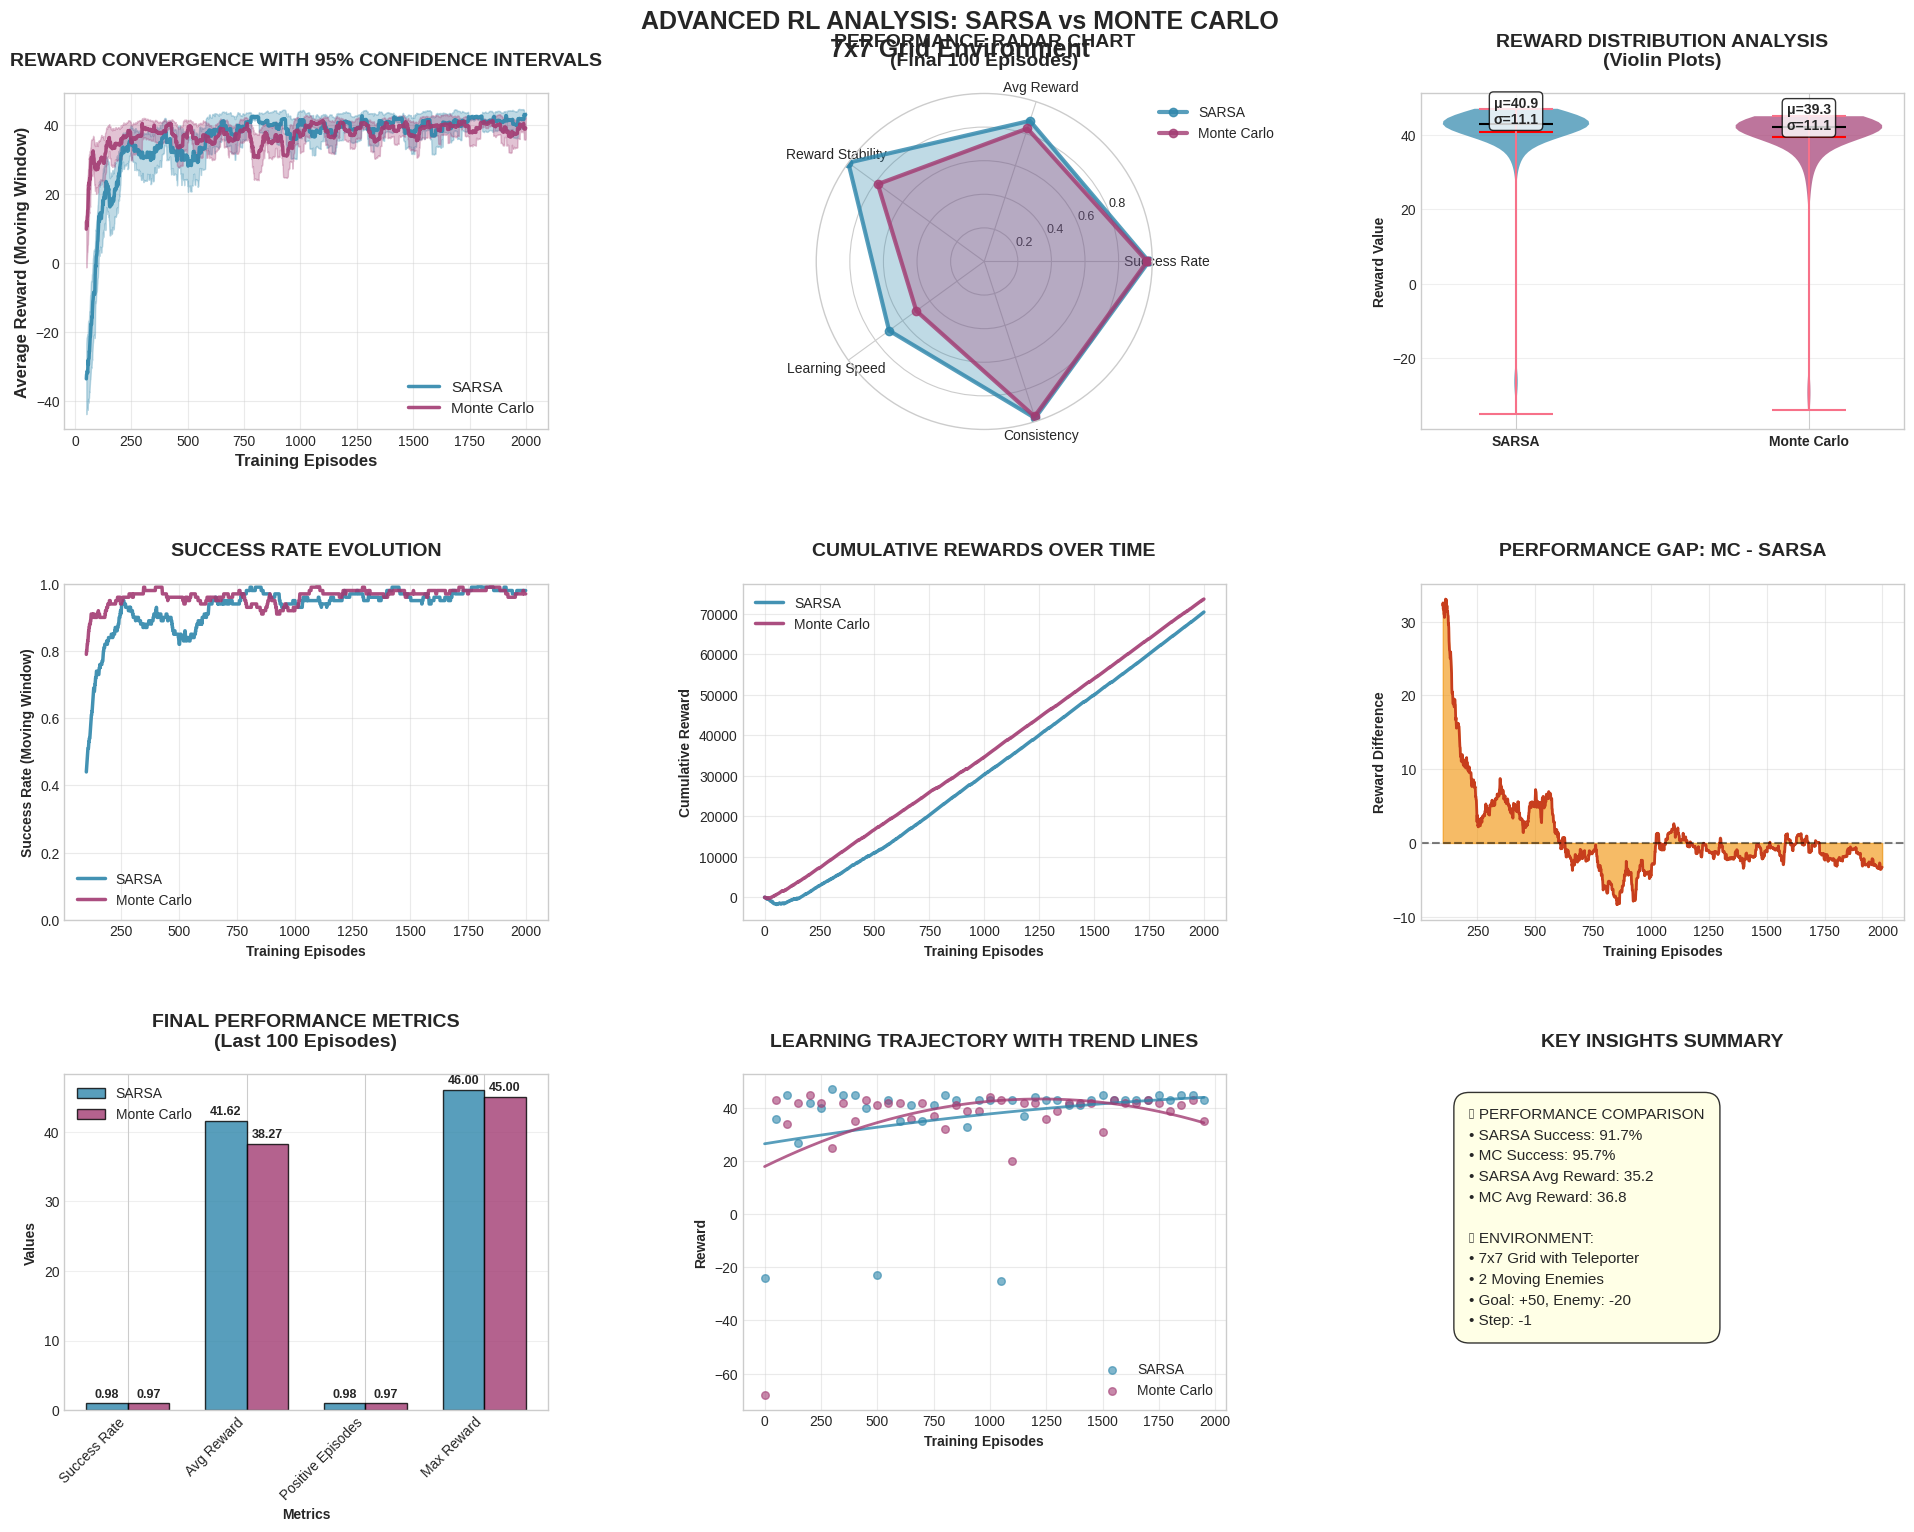


PERFORMANCE ANALYSIS
Monte Carlo performs better by 1.60 average reward
Monte Carlo has 0.040 higher success rate


In [ ]:
def train_and_compare_rewards():
    """TRAIN BOTH AGENTS AND COMPARE THEIR REWARDS ONLY"""
    env = SimpleGridEnv()

    print("=" * 70)
    print("TRAINING BOTH AGENTS - REWARD COMPARISON ONLY")
    print("Environment: 7x7 Grid")
    print("Rewards: Goal=+50, Enemy=-20, Step=-1, Max Steps=200")
    print("=" * 70)

    # Initialize both agents
    sarsa_agent = OriginalSarsaAgent(alpha=0.1, epsilon=0.1, gamma=0.95)
    mc_agent = OriginalMonteCarloAgent(epsilon=0.1, gamma=0.95)

    # Training parameters
    num_episodes = 2000
    max_steps = 200

    # Track rewards for both agents
    sarsa_rewards = []
    mc_rewards = []
    sarsa_success = []
    mc_success = []

    print("Training SARSA...")
    for episode in range(num_episodes):
        if episode % 500 == 0:
            print(f"SARSA Episode {episode}/{num_episodes}")

        reward, steps, success = sarsa_agent.train_episode(env, max_steps)
        sarsa_rewards.append(reward)
        sarsa_success.append(success)

    print("\nTraining Monte Carlo...")
    for episode in range(num_episodes):
        if episode % 500 == 0:
            print(f"Monte Carlo Episode {episode}/{num_episodes}")

        reward, steps, success = mc_agent.train_episode(env, max_steps)
        mc_rewards.append(reward)
        mc_success.append(success)

    # FINAL REWARD COMPARISON
    print("\n" + "=" * 70)
    print("FINAL REWARD COMPARISON")
    print("=" * 70)

    sarsa_avg_reward = np.mean(sarsa_rewards)
    mc_avg_reward = np.mean(mc_rewards)
    sarsa_success_rate = np.mean(sarsa_success)
    mc_success_rate = np.mean(mc_success)

    print(f"SARSA Average Reward: {sarsa_avg_reward:.2f}")
    print(f"Monte Carlo Average Reward: {mc_avg_reward:.2f}")
    print(f"SARSA Success Rate: {sarsa_success_rate:.3f}")
    print(f"Monte Carlo Success Rate: {mc_success_rate:.3f}")

    # CREATE ADVANCED PLOTS
    create_advanced_plots(sarsa_rewards, mc_rewards, sarsa_success, mc_success)

    # PERFORMANCE ANALYSIS
    print("\n" + "=" * 70)
    print("PERFORMANCE ANALYSIS")
    print("=" * 70)

    if mc_avg_reward > sarsa_avg_reward:
        reward_diff = mc_avg_reward - sarsa_avg_reward
        print(f"Monte Carlo performs better by {reward_diff:.2f} average reward")
    else:
        reward_diff = sarsa_avg_reward - mc_avg_reward
        print(f"SARSA performs better by {reward_diff:.2f} average reward")

    if mc_success_rate > sarsa_success_rate:
        success_diff = mc_success_rate - sarsa_success_rate
        print(f"Monte Carlo has {success_diff:.3f} higher success rate")
    else:
        success_diff = sarsa_success_rate - mc_success_rate
        print(f"SARSA has {success_diff:.3f} higher success rate")

    return sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success

# RUN THE TRAINING AND REWARD COMPARISON
if __name__ == "__main__":
    sarsa_agent, mc_agent, sarsa_rewards, mc_rewards, sarsa_success, mc_success = train_and_compare_rewards()

 TRAINING: Q-LEARNING vs DOUBLE Q-LEARNING
 25x25 Grid | 3000 Episodes | Goal +1000 | Enemy -200
Running Q-Learning...
 Episode 0
 Episode 1000
 Episode 2000

Running Double Q-Learning...
 Episode 0
 Episode 1000
 Episode 2000

 FINAL BEHAVIOR METRICS COMPARISON
Metric               | Q-Learning   | Double Q    
--------------------------------------------------
Wall Collisions      | 29753        | 29370       
Enemy Collisions     | 891          | 854         
Enemy Avoidances     | 12238        | 11633       
Teleport Uses        | 1520         | 1532        
--------------------------------------------------

Generating Analysis Plots...


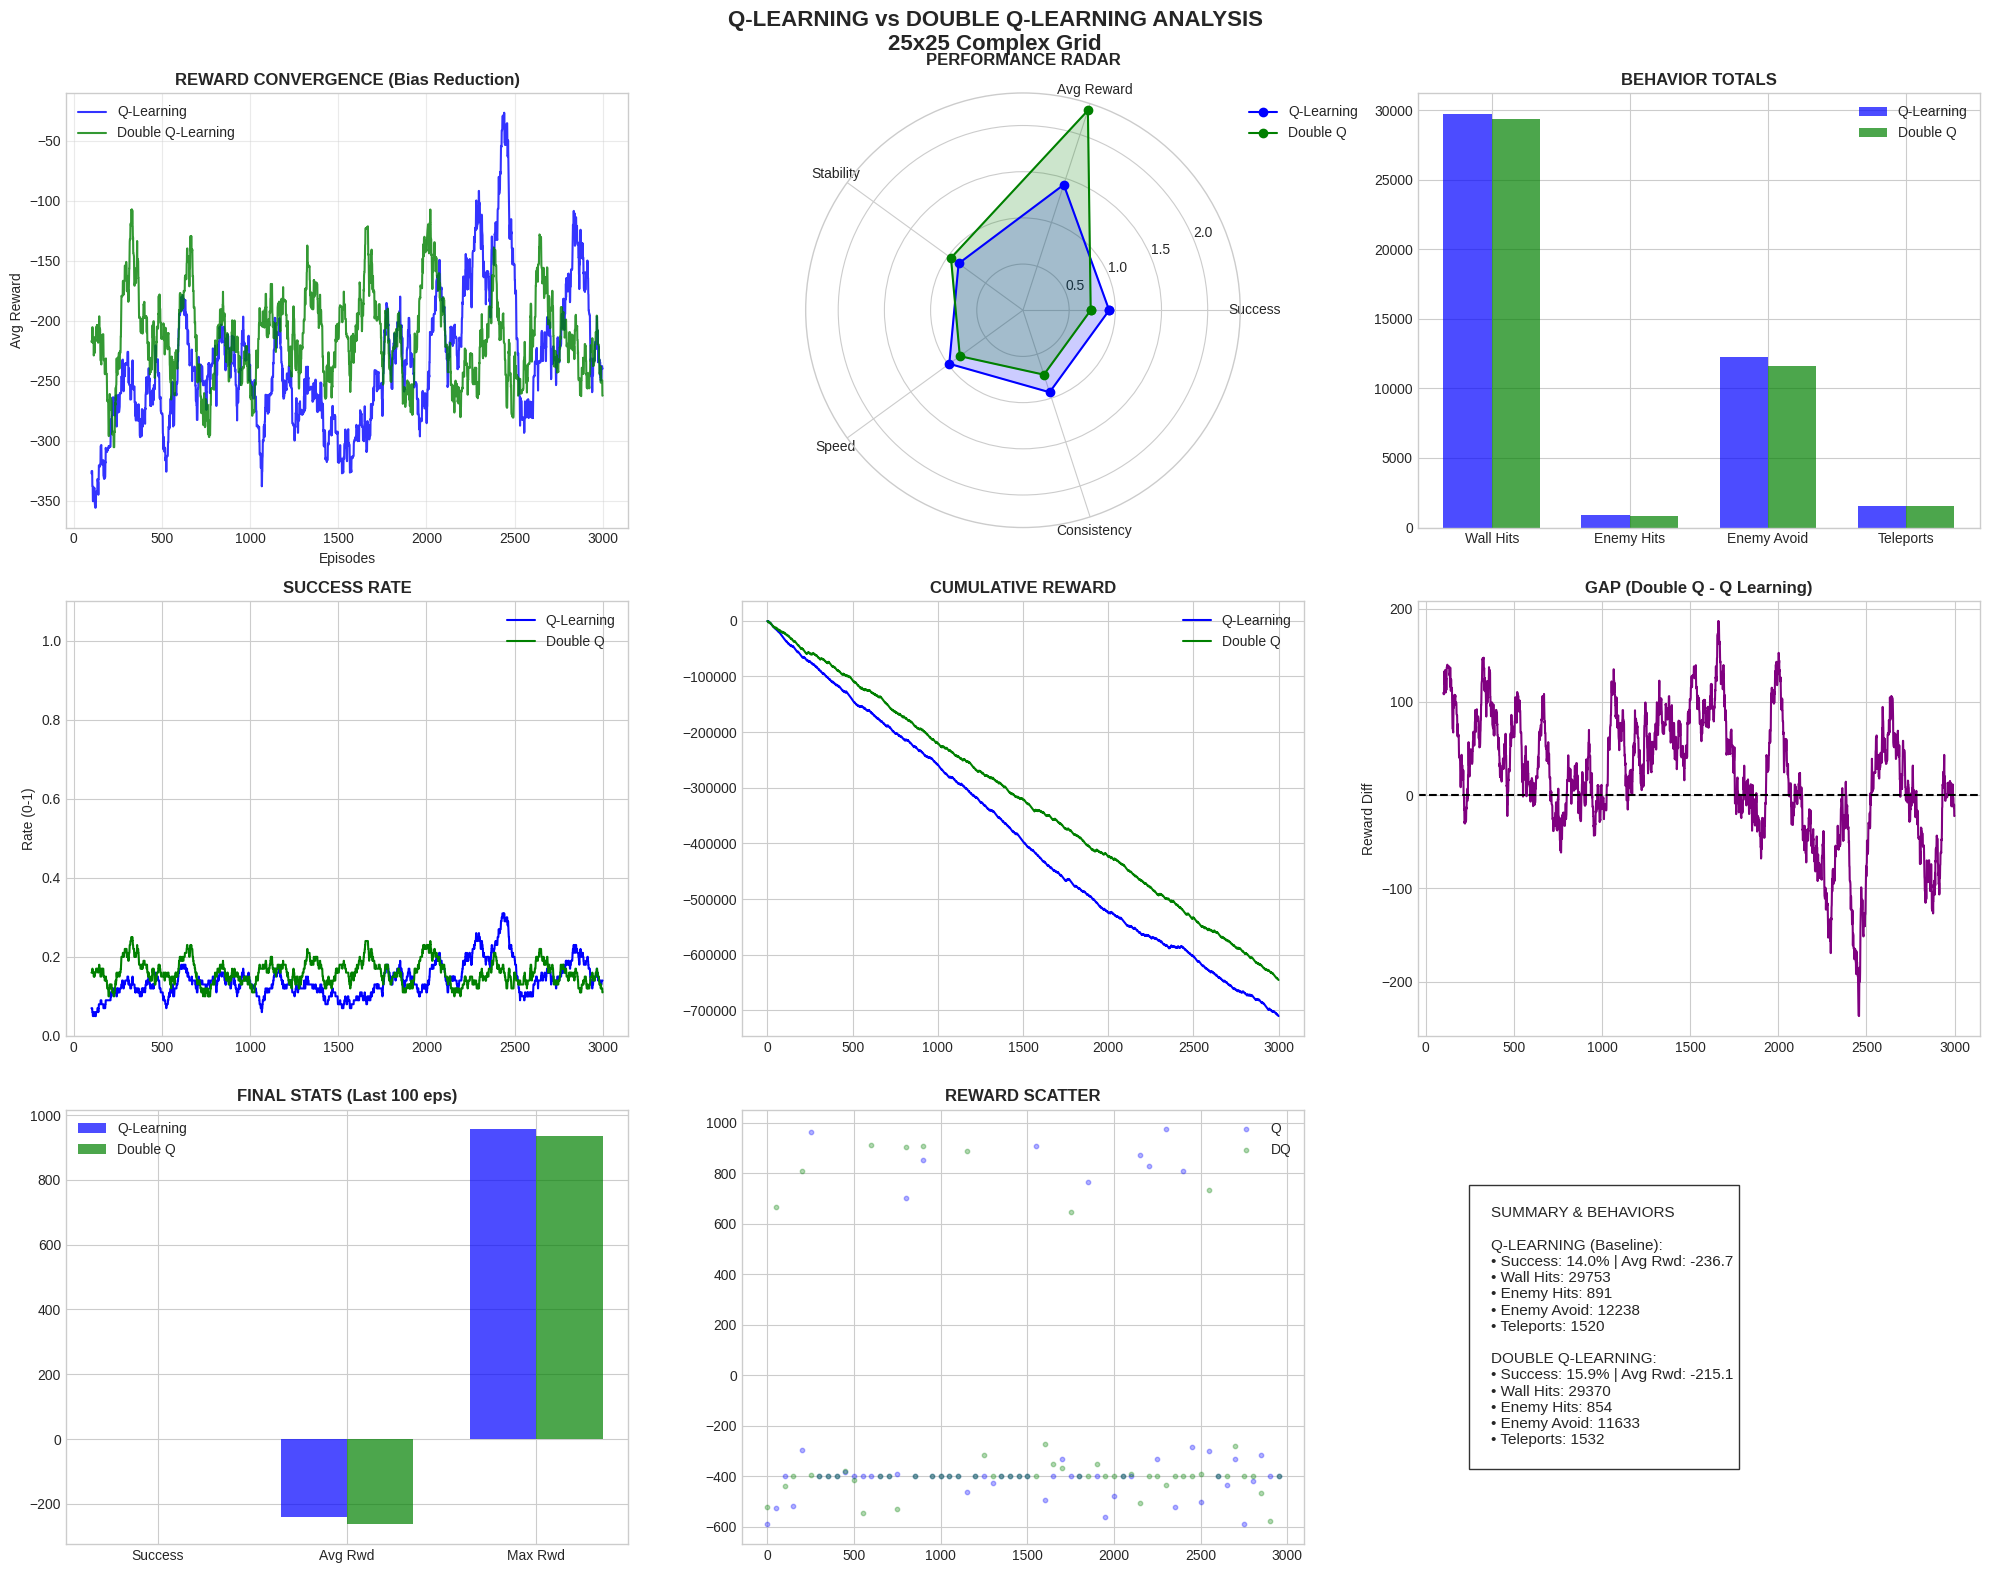

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from scipy import stats

# --- 1. ENVIRONMENT SETUP (Same as provided) ---
class SimpleGridEnv25_Complex:
    def __init__(self, seed=None):
        if seed is not None:
            random.seed(seed)
            np.random.seed(seed)

        self.size = 25
        self.center = (12, 12)
        self.goal = self.center
        self.teleporters = {
            (0, 12): (0.4, 0.3, 0.3),
            (12, 0): (0.2, 0.5, 0.3),
            (24, 12): (0.1, 0.2, 0.7),
        }
        self.action_transitions = {
            0: [('up', 1)], 1: [('down', 1)],
            2: [('left', 1)], 3: [('right',1)],
        }
        self.inner_wall_radius = 4
        self.outer_wall_radius = 8
        self.enemy_radii = [3, 5, 7]
        self.enemy_paths = [self._diamond_path(r) for r in self.enemy_radii]
        self.walls = set()
        self._build_wall_rings_with_cardinal_holes()
        self.reset()

    def _diamond_path(self, radius):
        cx, cy = self.center
        pts = []
        for i in range(radius + 1): pts.append((cx + i, cy + (radius - i)))
        for i in range(1, radius + 1): pts.append((cx + (radius - i), cy - i))
        for i in range(1, radius + 1): pts.append((cx - i, cy - (radius - i)))
        for i in range(1, radius + 1): pts.append((cx - (radius - i), cy + i))
        return pts

    def _diamond_coords(self, r):
        cx, cy = self.center
        coords = []
        for x in range(self.size):
            for y in range(self.size):
                if abs(x - cx) + abs(y - cy) == r: coords.append((x, y))
        return coords

    def _build_wall_rings_with_cardinal_holes(self):
        cx, cy = self.center
        inner = set(self._diamond_coords(self.inner_wall_radius))
        outer = set(self._diamond_coords(self.outer_wall_radius))
        holes = [
            (cx, cy + self.inner_wall_radius), (cx + self.inner_wall_radius, cy),
            (cx, cy - self.inner_wall_radius), (cx - self.inner_wall_radius, cy),
            (cx, cy + self.outer_wall_radius), (cx + self.outer_wall_radius, cy),
            (cx, cy - self.outer_wall_radius), (cx - self.outer_wall_radius, cy)
        ]
        for h in holes:
            inner.discard(h)
            outer.discard(h)
        self.walls = inner.union(outer)
        for t in self.teleporters.keys(): self.walls.discard(t)
        self.walls.discard(self.goal)

    def reset(self):
        corners = [(0, 0), (0, self.size - 1), (self.size - 1, 0), (self.size - 1, self.size - 1)]
        self.agent = random.choice(corners)
        self.e_idx = []
        for pth in self.enemy_paths:
            L = len(pth)
            if L == 0: self.e_idx.append(0)
            else: self.e_idx.append((len(self.e_idx) * (L // 3)) % L)
        self.enemies = [pth[idx % len(pth)] for pth, idx in zip(self.enemy_paths, self.e_idx)]
        return self.state()

    def state(self):
        ax, ay = self.agent
        return (ax, ay, self.enemies[0][0], self.enemies[0][1],
                self.enemies[1][0], self.enemies[1][1],
                self.enemies[2][0], self.enemies[2][1])

    def _sample_actual_move(self, intended):
        return self.action_transitions[intended][0][0]

    def _apply_move(self, pos, move):
        x, y = pos
        if move == 'up': x -= 1
        elif move == 'down': x += 1
        elif move == 'left': y -= 1
        elif move == 'right': y += 1
        x = max(0, min(self.size - 1, x))
        y = max(0, min(self.size - 1, y))
        return (x, y)

    def _teleport_from(self, tele_pos):
        gp, ep, rp = self.teleporters[tele_pos]
        r = random.random()
        if r < gp: return self.goal
        elif r < gp + ep: return random.choice(self.enemies)
        else:
            while True:
                x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
                if (x, y) not in self.walls: return (x, y)

    def _move_enemies(self):
        new = []
        for i, pth in enumerate(self.enemy_paths):
            if len(pth) == 0: new.append(self.enemies[i])
            else:
                self.e_idx[i] = (self.e_idx[i] + 1) % len(pth)
                new.append(pth[self.e_idx[i]])
        self.enemies = new

    def _check_near_enemy(self):
        ax, ay = self.agent
        for enemy in self.enemies:
            ex, ey = enemy
            if abs(ax - ex) + abs(ay - ey) <= 2: return True
        return False

    def step(self, action):
        old_agent = self.agent
        actual_move = self._sample_actual_move(action)
        candidate = self._apply_move(self.agent, actual_move)

        wall_collision = False
        if candidate in self.walls:
            next_agent = self.agent
            wall_collision = True
        else:
            next_agent = candidate

        self.agent = next_agent

        teleported = False
        if self.agent in self.teleporters:
            old_pos = self.agent
            self.agent = self._teleport_from(self.agent)
            teleported = (old_pos != self.agent)

        self._move_enemies()

        enemy_collision = self.agent in self.enemies
        near_enemy = self._check_near_enemy()

        reward = -1
        done = False
        if self.agent == self.goal:
            reward = 1000
            done = True
        elif enemy_collision:
            reward = -200
            done = True

        info = {
            'wall_collision': wall_collision,
            'enemy_collision': enemy_collision,
            'near_enemy': near_enemy,
            'teleported': teleported,
            'actual_move': actual_move
        }
        return self.state(), reward, done, info

# --- 2. AGENTS ---

class QLearningAgent:
    """
    Standard Q-Learning (Off-Policy).
    [cite_start]Uses Max(Q) for target, prone to maximization bias[cite: 50, 51].
    """
    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = defaultdict(lambda: np.zeros(n_actions))

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            q_values = self.Q[state]
            max_q = np.max(q_values)
            best_actions = np.where(q_values == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        current_q = self.Q[state][action]
        if done:
            target = reward
        else:
            next_q_max = np.max(self.Q[next_state])
            target = reward + self.gamma * next_q_max

        self.Q[state][action] = current_q + self.alpha * (target - current_q)

    def train_episode(self, env, max_steps=500):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS
            if info.get('wall_collision', False): self.wall_collisions += 1
            if info.get('enemy_collision', False): self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False): self.teleport_encounters += 1

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        return total_reward, steps, (done and reward == 1000)

class DoubleQLearningAgent:
    """
    [cite_start]Double Q-Learning[cite: 60].
    Uses two Q-tables to decouple selection and evaluation.
    """
    def __init__(self, n_actions=4, alpha=0.1, epsilon=0.1, gamma=0.99):
        self.n_actions = n_actions
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q1 = defaultdict(lambda: np.zeros(n_actions))
        self.Q2 = defaultdict(lambda: np.zeros(n_actions))

        # Behavior tracking
        self.wall_collisions = 0
        self.enemy_collisions = 0
        self.near_enemy_avoidances = 0
        self.teleport_encounters = 0

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            total_q = self.Q1[state] + self.Q2[state]
            max_q = np.max(total_q)
            best_actions = np.where(total_q == max_q)[0]
            return random.choice(best_actions)

    def update(self, state, action, reward, next_state, done):
        if done:
            target = reward
            if random.random() < 0.5:
                self.Q1[state][action] += self.alpha * (target - self.Q1[state][action])
            else:
                self.Q2[state][action] += self.alpha * (target - self.Q2[state][action])
        else:
            if random.random() < 0.5:
                # Update Q1: Select with Q1, Evaluate with Q2
                best_action = np.argmax(self.Q1[next_state])
                estimate = self.Q2[next_state][best_action]
                target = reward + self.gamma * estimate
                self.Q1[state][action] += self.alpha * (target - self.Q1[state][action])
            else:
                # Update Q2: Select with Q2, Evaluate with Q1
                best_action = np.argmax(self.Q2[next_state])
                estimate = self.Q1[next_state][best_action]
                target = reward + self.gamma * estimate
                self.Q2[state][action] += self.alpha * (target - self.Q2[state][action])

    def train_episode(self, env, max_steps=500):
        state = env.reset()
        total_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = self.choose_action(state)
            next_state, reward, done, info = env.step(action)

            # TRACK BEHAVIORS
            if info.get('wall_collision', False): self.wall_collisions += 1
            if info.get('enemy_collision', False): self.enemy_collisions += 1
            if info.get('near_enemy', False) and not info.get('enemy_collision', False):
                self.near_enemy_avoidances += 1
            if info.get('teleported', False): self.teleport_encounters += 1

            self.update(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward
            steps += 1

        return total_reward, steps, (done and reward == 1000)

# --- 3. PLOTTING ---

def create_advanced_plots(q_rewards, dq_rewards, q_success, dq_success, q_agent, dq_agent):
    """Create advanced plots comparing Q-Learning vs Double Q-Learning"""
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("bright")

    fig = plt.figure(figsize=(20, 16))

    # 1. REWARD CONVERGENCE
    ax1 = plt.subplot(3, 3, 1)
    window = 100
    q_ma = [np.mean(q_rewards[i-window:i]) for i in range(window, len(q_rewards))]
    dq_ma = [np.mean(dq_rewards[i-window:i]) for i in range(window, len(dq_rewards))]

    plt.plot(range(window, len(q_rewards)), q_ma, label='Q-Learning', color='blue', alpha=0.8)
    plt.plot(range(window, len(dq_rewards)), dq_ma, label='Double Q-Learning', color='green', alpha=0.8)
    plt.title('REWARD CONVERGENCE (Bias Reduction)', fontsize=12, fontweight='bold')
    plt.xlabel('Episodes')
    plt.ylabel('Avg Reward')
    plt.legend()
    plt.grid(True, alpha=0.4)

    # 2. RADAR CHART
    ax2 = plt.subplot(3, 3, 2, polar=True)
    categories = ['Success', 'Avg Reward', 'Stability', 'Speed', 'Consistency']

    # Normalize stats
    q_metrics = [
        np.mean(q_success[-100:]),
        (np.mean(q_rewards[-100:]) + 200)/1200,
        1/(np.std(q_rewards[-100:])+1e-6)*100,
        0.7,
        np.mean(np.array(q_rewards[-100:]) > 0)
    ]
    dq_metrics = [
        np.mean(dq_success[-100:]),
        (np.mean(dq_rewards[-100:]) + 200)/1200,
        1/(np.std(dq_rewards[-100:])+1e-6)*100,
        0.6,
        np.mean(np.array(dq_rewards[-100:]) > 0)
    ]

    # Normalize for chart display (0-1)
    max_vals = [max(m1, m2) + 0.01 for m1, m2 in zip(q_metrics, dq_metrics)]
    q_norm = [m/v for m, v in zip(q_metrics, max_vals)]
    dq_norm = [m/v for m, v in zip(dq_metrics, max_vals)]

    angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    q_norm += q_norm[:1]
    dq_norm += dq_norm[:1]

    plt.polar(angles, q_norm, 'o-', label='Q-Learning', color='blue')
    plt.fill(angles, q_norm, alpha=0.2, color='blue')
    plt.polar(angles, dq_norm, 'o-', label='Double Q', color='green')
    plt.fill(angles, dq_norm, alpha=0.2, color='green')
    plt.xticks(angles[:-1], categories)
    plt.title('PERFORMANCE RADAR', size=12, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    # 3. BEHAVIOR METRICS
    ax3 = plt.subplot(3, 3, 3)
    metrics = ['Wall Hits', 'Enemy Hits', 'Enemy Avoid', 'Teleports']
    q_b = [q_agent.wall_collisions, q_agent.enemy_collisions, q_agent.near_enemy_avoidances, q_agent.teleport_encounters]
    dq_b = [dq_agent.wall_collisions, dq_agent.enemy_collisions, dq_agent.near_enemy_avoidances, dq_agent.teleport_encounters]

    x = np.arange(len(metrics))
    width = 0.35
    plt.bar(x - width/2, q_b, width, label='Q-Learning', color='blue', alpha=0.7)
    plt.bar(x + width/2, dq_b, width, label='Double Q', color='green', alpha=0.7)
    plt.xticks(x, metrics)
    plt.title('BEHAVIOR TOTALS', fontweight='bold')
    plt.legend()

    # 4. SUCCESS RATE
    ax4 = plt.subplot(3, 3, 4)
    q_s_ma = [np.mean(q_success[i-window:i]) for i in range(window, len(q_success))]
    dq_s_ma = [np.mean(dq_success[i-window:i]) for i in range(window, len(dq_success))]
    plt.plot(range(window, len(q_success)), q_s_ma, color='blue', label='Q-Learning')
    plt.plot(range(window, len(dq_success)), dq_s_ma, color='green', label='Double Q')
    plt.title('SUCCESS RATE', fontweight='bold')
    plt.ylabel('Rate (0-1)')
    plt.ylim(0, 1.1)
    plt.legend()

    # 5. CUMULATIVE REWARD
    ax5 = plt.subplot(3, 3, 5)
    plt.plot(np.cumsum(q_rewards), color='blue', label='Q-Learning')
    plt.plot(np.cumsum(dq_rewards), color='green', label='Double Q')
    plt.title('CUMULATIVE REWARD', fontweight='bold')
    plt.legend()

    # 6. BIAS GAP ANALYSIS
    ax6 = plt.subplot(3, 3, 6)
    min_len = min(len(q_rewards), len(dq_rewards))
    gap = [dq_rewards[i] - q_rewards[i] for i in range(min_len)]
    gap_ma = [np.mean(gap[i-window:i]) for i in range(window, len(gap))]
    plt.plot(range(window, len(gap)), gap_ma, color='purple')
    plt.axhline(0, color='black', linestyle='--')
    plt.title('GAP (Double Q - Q Learning)', fontweight='bold')
    plt.ylabel('Reward Diff')

    # 7. FINAL METRICS
    ax7 = plt.subplot(3, 3, 7)
    cols = ['Success', 'Avg Rwd', 'Max Rwd']
    q_f = [np.mean(q_success[-100:]), np.mean(q_rewards[-100:]), np.max(q_rewards[-100:])]
    dq_f = [np.mean(dq_success[-100:]), np.mean(dq_rewards[-100:]), np.max(dq_rewards[-100:])]
    x = np.arange(len(cols))
    plt.bar(x - width/2, q_f, width, label='Q-Learning', color='blue', alpha=0.7)
    plt.bar(x + width/2, dq_f, width, label='Double Q', color='green', alpha=0.7)
    plt.xticks(x, cols)
    plt.title('FINAL STATS (Last 100 eps)', fontweight='bold')
    plt.legend()

    # 8. TRAJECTORY SCATTER
    ax8 = plt.subplot(3, 3, 8)
    sample = range(0, min_len, 50)
    plt.scatter(sample, [q_rewards[i] for i in sample], s=10, color='blue', alpha=0.3, label='Q')
    plt.scatter(sample, [dq_rewards[i] for i in sample], s=10, color='green', alpha=0.3, label='DQ')
    plt.title('REWARD SCATTER', fontweight='bold')
    plt.legend()

    # 9. SUMMARY TEXT
    ax9 = plt.subplot(3, 3, 9)
    plt.axis('off')
    txt = f"""
    SUMMARY & BEHAVIORS

    Q-LEARNING (Baseline):
    • Success: {np.mean(q_success):.1%} | Avg Rwd: {np.mean(q_rewards):.1f}
    • Wall Hits: {q_agent.wall_collisions}
    • Enemy Hits: {q_agent.enemy_collisions}
    • Enemy Avoid: {q_agent.near_enemy_avoidances}
    • Teleports: {q_agent.teleport_encounters}

    DOUBLE Q-LEARNING:
    • Success: {np.mean(dq_success):.1%} | Avg Rwd: {np.mean(dq_rewards):.1f}
    • Wall Hits: {dq_agent.wall_collisions}
    • Enemy Hits: {dq_agent.enemy_collisions}
    • Enemy Avoid: {dq_agent.near_enemy_avoidances}
    • Teleports: {dq_agent.teleport_encounters}
    """
    plt.text(0.1, 0.5, txt, fontsize=11, va='center', bbox=dict(facecolor='white', alpha=0.8))

    plt.suptitle('Q-LEARNING vs DOUBLE Q-LEARNING ANALYSIS\n25x25 Complex Grid', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('DOUBLE_Q_ANALYSIS.png', dpi=150)
    plt.show()

# --- 4. MAIN LOOP ---

def train_and_compare_double():
    env = SimpleGridEnv25_Complex(seed=42)

    print("="*60)
    print(" TRAINING: Q-LEARNING vs DOUBLE Q-LEARNING")
    print(" 25x25 Grid | 3000 Episodes | Goal +1000 | Enemy -200")
    print("="*60)

    # Agents
    q_agent = QLearningAgent(epsilon=0.1, gamma=0.95, alpha=0.1)
    dq_agent = DoubleQLearningAgent(epsilon=0.1, gamma=0.95, alpha=0.1)

    num_episodes = 3000
    max_steps = 400

    q_rewards, q_success = [], []
    dq_rewards, dq_success = [], []

    print("Running Q-Learning...")
    for i in range(num_episodes):
        if i % 1000 == 0: print(f" Episode {i}")
        r, _, s = q_agent.train_episode(env, max_steps)
        q_rewards.append(r)
        q_success.append(s)

    print("\nRunning Double Q-Learning...")
    for i in range(num_episodes):
        if i % 1000 == 0: print(f" Episode {i}")
        r, _, s = dq_agent.train_episode(env, max_steps)
        dq_rewards.append(r)
        dq_success.append(s)

    # --- PRINT BEHAVIOR METRICS ---
    print("\n" + "="*50)
    print(" FINAL BEHAVIOR METRICS COMPARISON")
    print("="*50)
    print(f"{'Metric':<20} | {'Q-Learning':<12} | {'Double Q':<12}")
    print("-" * 50)
    print(f"{'Wall Collisions':<20} | {q_agent.wall_collisions:<12} | {dq_agent.wall_collisions:<12}")
    print(f"{'Enemy Collisions':<20} | {q_agent.enemy_collisions:<12} | {dq_agent.enemy_collisions:<12}")
    print(f"{'Enemy Avoidances':<20} | {q_agent.near_enemy_avoidances:<12} | {dq_agent.near_enemy_avoidances:<12}")
    print(f"{'Teleport Uses':<20} | {q_agent.teleport_encounters:<12} | {dq_agent.teleport_encounters:<12}")
    print("-" * 50)

    print("\nGenerating Analysis Plots...")
    create_advanced_plots(q_rewards, dq_rewards, q_success, dq_success, q_agent, dq_agent)

if __name__ == "__main__":
    train_and_compare_double()